# Library import

In [ ]:
import numpy as np 
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
from counterplots import CreatePlot

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as imbalanced_make_pipeline

from sklearn.pipeline import Pipeline
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import KMeans
from sklearn.compose import ColumnTransformer
from sklearn.metrics import accuracy_score, silhouette_score, roc_auc_score, recall_score, precision_score, make_scorer, fbeta_score, silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

from autogluon.tabular import TabularDataset, TabularPredictor
from autogluon.core.metrics import make_scorer as ag_make_scorer

from xgboost import XGBClassifier

from scipy.spatial.distance import cdist
import dice_ml
import keras

from collections import Counter
import copy
import time
import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', None)

# Data load

In [2]:
df = pd.read_csv("Data/Dropout_students.csv", delimiter=',')
df.set_index("Fake_StudentID", inplace=True)

df["Target"] = df["Target"].apply(lambda x: 0 if x == "No dropout" else 1)

# Numeric features
df_numeric_features = ["Previous_qualification_(grade)", "Admission_grade", "Age_at_enrollment", "Curricular_units_1st_sem_(credited)", "Curricular_units_1st_sem_(enrolled)", 
                        "Curricular_units_1st_sem_(evaluations)", "Curricular_units_1st_sem_(approved)", "Curricular_units_1st_sem_(grade)", "Curricular_units_1st_sem_(without_evaluations)", 
                        "Curricular_units_2nd_sem_(credited)", "Curricular_units_2nd_sem_(enrolled)", "Curricular_units_2nd_sem_(evaluations)", "Curricular_units_2nd_sem_(approved)", 
                        "Curricular_units_2nd_sem_(grade)", "Curricular_units_2nd_sem_(without_evaluations)", "Unemployment_rate", "Inflation_rate", "GDP"]

# Continuous numeric features
df_numeric_continuous_features = ["Previous_qualification_(grade)", "Admission_grade", "Age_at_enrollment", "Curricular_units_1st_sem_(grade)", "Curricular_units_2nd_sem_(grade)", "Unemployment_rate", "Inflation_rate", "GDP"]

# Discrete numeric features
df_numeric_discrete_features = [col for col in df_numeric_features if col not in df_numeric_continuous_features and col != 'Target']

# Categorical features
df_categorical_features = [col for col in df.columns if col not in df_numeric_features and col != 'Target']

# Nominal categorical features
df_categorical_nominal_features = ["Marital_status", "Application_mode", "Course", "Previous_qualification", "Nacionality", "Mother's_qualification", "Father's_qualification", "Mother's_occupation",	"Father's_occupation"]

# Ordinal categorical features
df_categorical_ordinal_features = ["Application_order"]

# Binary categorical features
df_categorical_binary_features = [col for col in df_categorical_features if col not in set(df_categorical_nominal_features) | set(df_categorical_ordinal_features) and col != 'Target']

df[df_categorical_features] = df[df_categorical_features].astype(int)
df[df_numeric_discrete_features] = df[df_numeric_discrete_features].astype(int)
df[df_numeric_continuous_features] = df[df_numeric_continuous_features].astype(float)

In [3]:
df.head()

,Marital_status,Application_mode,Application_order,Course,Daytime/evening_attendance,Previous_qualification,Previous_qualification_(grade),Nacionality,Mother's_qualification,Father's_qualification,Mother's_occupation,Father's_occupation,Admission_grade,Displaced,Educational_special_needs,Debtor,Tuition_fees_up_to_date,Gender,Scholarship_holder,Age_at_enrollment,International,Curricular_units_1st_sem_(credited),Curricular_units_1st_sem_(enrolled),Curricular_units_1st_sem_(evaluations),Curricular_units_1st_sem_(approved),Curricular_units_1st_sem_(grade),Curricular_units_1st_sem_(without_evaluations),Curricular_units_2nd_sem_(credited),Curricular_units_2nd_sem_(enrolled),Curricular_units_2nd_sem_(evaluations),Curricular_units_2nd_sem_(approved),Curricular_units_2nd_sem_(grade),Curricular_units_2nd_sem_(without_evaluations),Unemployment_rate,Inflation_rate,GDP,Target
Fake_StudentID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
36720932C,1,17,5,171,1,1,122.0,1,19,12,5,9,127.3,1,0,0,1,1,0,20.0,0,0,0,0,0,0.000000,0,0,0,0,0,0.000000,0,10.8,1.4,1.74,1
85167446C,1,15,1,9254,1,1,160.0,1,1,3,3,3,142.5,1,0,0,0,1,0,19.0,0,0,6,6,6,14.000000,0,0,6,6,6,13.666667,0,13.9,-0.3,0.79,0
14519294A,1,1,5,9070,1,1,122.0,1,37,37,9,9,124.8,1,0,0,0,1,0,19.0,0,0,6,0,0,0.000000,0,0,6,0,0,0.000000,0,10.8,1.4,1.74,1
89143675D,1,17,2,9773,1,1,122.0,1,38,37,5,3,119.6,1,0,0,1,0,0,20.0,0,0,6,8,6,13.428571,0,0,6,10,5,12.400000,0,9.4,-0.8,-3.12,0
57640183A,2,39,1,8014,0,1,100.0,1,37,38,9,9,141.5,0,0,0,1,0,0,45.0,0,0,6,9,5,12.333333,0,0,6,6,6,13.000000,0,13.9,-0.3,0.79,0


In [4]:
for col in df.columns:
    print(col)
    print(df[col].value_counts())
    print()

Marital_status
Marital_status
1    3912
2     379
4      91
5      25
6       6
3       4
Name: count, dtype: int64

Application_mode
Application_mode
1     1703
17     872
39     785
43     312
44     212
7      139
18     124
42      77
51      59
16      38
53      35
15      30
5       16
10       9
2        3
57       1
26       1
27       1
Name: count, dtype: int64

Application_order
Application_order
1    3021
2     546
3     309
4     249
5     154
6     136
9       1
0       1
Name: count, dtype: int64

Course
Course
9500    765
9147    379
9238    355
9085    337
9773    328
9670    268
9991    268
9254    252
9070    224
171     215
8014    215
9003    210
9853    192
9119    170
9130    141
9556     86
33       12
Name: count, dtype: int64

Daytime/evening_attendance
Daytime/evening_attendance
1    3934
0     483
Name: count, dtype: int64

Previous_qualification
Previous_qualification
1     3711
39     218
19     162
3      126
12      45
40      40
42      36
2       23
6

---------------------------------------------------------------------------------------------------------
# EDA

In [5]:
# Function to plot histograms and boxplots for numeric features, and count plots for categorical features

def plot_variables_custom(df, numeric_features, categorical_features, rows, cols, suptitle):
    # Create subplots with specified rows and columns
    fig, axs = plt.subplots(rows, cols, figsize=(20, 25))
    
    # Set the main title for the figure
    fig.suptitle(suptitle, y=1, size=25)
    
    # Flatten the axes array to simplify indexing
    axs = axs.flatten()
    
    # Plot histograms with KDE and boxplots for numeric features
    for i, col in enumerate(numeric_features):
        sns.histplot(df[col], kde=True, ax=axs[i])  # Histogram with KDE line
        axs[i].set_title(f'{col}\nSkewness: {round(df[col].skew(), 2)}')  # Add title with skewness
        axs[i].set_xlabel('')  # Remove x-axis label for clarity
        
        # Add a secondary axis for the boxplot
        ax2 = axs[i].twinx()  
        sns.boxplot(data=df, x=df[col], ax=ax2, color='orange', boxprops=dict(alpha=0.3))  # Transparent boxplot
        ax2.set_ylabel('')  # Remove y-axis label on the secondary axis
        ax2.grid(False)  # Disable grid on the boxplot axis

    # Plot count plots for categorical features
    for i, col in enumerate(categorical_features):
        # Check if there is space left in the plot
        if i + len(numeric_features) < len(axs):  
            sns.countplot(data=df, x=df[col], ax=axs[i + len(numeric_features)], palette='Set2')  # Count plot
            axs[i + len(numeric_features)].set_title(col)  # Add title to count plot
            axs[i + len(numeric_features)].set_xticklabels(axs[i + len(numeric_features)].get_xticklabels(), rotation=45, ha="right")  # Rotate labels for better readability

    # Turn off unused axes
    for j in range(len(numeric_features) + len(categorical_features), len(axs)):
        axs[j].axis('off')
    
    # Adjust layout to prevent overlap
    plt.tight_layout(rect=[0, 0, 1, 0.97])  
    plt.show()


In [6]:
# Function to detect and handle outliers in numeric features
def detect_and_handle_outliers(df, numeric_features, continuous_threshold=3.5):
    df_outliers_handled = df.copy()  # Create a copy of the original dataframe
    
    outliers_count = {}  # Dictionary to store the count of outliers per column

    for col in df_outliers_handled.columns:
        if df_outliers_handled[col].name in numeric_features:
            # Calculate the z-scores to detect outliers
            mean = np.mean(df_outliers_handled[col])
            std = np.std(df_outliers_handled[col])
            z_scores = (df_outliers_handled[col] - mean) / std
            
            # Identify rows with outliers based on z-scores
            outliers_index = df_outliers_handled.index[np.abs(z_scores) > continuous_threshold]

            outliers_count[col] = len(outliers_index)  # Store the number of outliers
            
            # Drop the outlier rows from the dataframe
            df_outliers_handled = df_outliers_handled.drop(outliers_index)

    # Print the number of outliers detected in each numeric column
    for col, count in outliers_count.items():
        print(f"Column '{col}': {count} outliers")

    return df_outliers_handled  # Return the dataframe with outliers removed

In [7]:
# Function to preprocess the dataset by scaling numeric features.
# Note: In the end, this preprocessing was not used because the unpreprocessed data gave better results

def preprocess_df(df, numeric_features):
    original_order = list(df.columns)  # Store the original column order for reference
    
    # Define a pipeline to scale numeric features using StandardScaler
    numeric_transformer = Pipeline(steps=[
        ('scaler', StandardScaler())])

    # ColumnTransformer to apply transformations
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, numeric_features)],  # Scaling numeric features
        verbose_feature_names_out=False,  # Keep original feature names in the output
        remainder='passthrough')  # Keep the remaining columns unchanged

    preprocessor.set_output(transform="pandas")  # Ensure output is a pandas DataFrame
    transformed_df = preprocessor.fit_transform(df)  # Apply the transformations

    # Fit individual transformers (for potential future use)
    numeric_transformer.fit(df[numeric_features])
    
    # Return the transformed DataFrame and the fitted transformers
    return transformed_df, preprocessor, numeric_transformer

In [8]:
df.describe()

,Marital_status,Application_mode,Application_order,Course,Daytime/evening_attendance,Previous_qualification,Previous_qualification_(grade),Nacionality,Mother's_qualification,Father's_qualification,Mother's_occupation,Father's_occupation,Admission_grade,Displaced,Educational_special_needs,Debtor,Tuition_fees_up_to_date,Gender,Scholarship_holder,Age_at_enrollment,International,Curricular_units_1st_sem_(credited),Curricular_units_1st_sem_(enrolled),Curricular_units_1st_sem_(evaluations),Curricular_units_1st_sem_(approved),Curricular_units_1st_sem_(grade),Curricular_units_1st_sem_(without_evaluations),Curricular_units_2nd_sem_(credited),Curricular_units_2nd_sem_(enrolled),Curricular_units_2nd_sem_(evaluations),Curricular_units_2nd_sem_(approved),Curricular_units_2nd_sem_(grade),Curricular_units_2nd_sem_(without_evaluations),Unemployment_rate,Inflation_rate,GDP,Target
count,4417.000000,4417.000000,4417.000000,4417.000000,4417.000000,4417.000000,4417.000000,4417.000000,4417.000000,4417.000000,4417.000000,4417.000000,4417.000000,4417.000000,4417.000000,4417.000000,4417.000000,4417.000000,4417.000000,4417.000000,4417.000000,4417.000000,4417.000000,4417.000000,4417.000000,4417.000000,4417.000000,4417.000000,4417.000000,4417.000000,4417.000000,4417.000000,4417.000000,4417.000000,4417.000000,4417.000000,4417.000000
mean,1.178854,18.685307,1.727643,8855.712248,0.890650,4.574825,132.600928,1.846276,19.566221,22.276206,10.967625,11.037808,126.964206,0.548110,0.011546,0.113652,0.880688,0.351823,0.248132,23.268282,0.024451,0.710663,6.270772,8.301562,4.704777,10.636786,0.137876,0.541544,6.231605,8.064523,4.435590,10.226312,0.150328,11.562961,1.228481,0.003763,0.321259
std,0.606185,17.483782,1.313027,2065.030660,0.312113,10.210705,13.169100,6.736813,15.599181,15.338622,26.438490,25.282519,14.477566,0.497736,0.106844,0.317424,0.324192,0.477593,0.431978,7.591965,0.154462,2.362152,2.482008,4.181739,3.096246,4.846249,0.691406,1.918790,2.197045,3.950458,3.016032,5.213910,0.754243,2.662982,1.382402,2.269961,0.467013
min,1.000000,1.000000,0.000000,33.000000,0.000000,1.000000,95.000000,1.000000,1.000000,1.000000,0.000000,0.000000,95.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,17.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,7.600000,-0.800000,-4.060000,0.000000
25%,1.000000,1.000000,1.000000,9085.000000,1.000000,1.000000,125.000000,1.000000,2.000000,3.000000,4.000000,4.000000,117.900000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,19.000000,0.000000,0.000000,5.000000,6.000000,3.000000,11.000000,0.000000,0.000000,5.000000,6.000000,2.000000,10.750000,0.000000,9.400000,0.300000,-1.700000,0.000000
50%,1.000000,17.000000,1.000000,9238.000000,1.000000,1.000000,133.100000,1.000000,19.000000,19.000000,5.000000,7.000000,126.100000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,20.000000,0.000000,0.000000,6.000000,8.000000,5.000000,12.285714,0.000000,0.000000,6.000000,8.000000,5.000000,12.200000,0.000000,11.100000,1.400000,0.320000,0.000000
75%,1.000000,39.000000,2.000000,9556.000000,1.000000,1.000000,140.000000,1.000000,37.000000,37.000000,9.000000,9.000000,134.800000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,25.000000,0.000000,0.000000,7.000000,10.000000,6.000000,13.394737,0.000000,0.000000,7.000000,10.000000,6.000000,13.333333,0.000000,13.900000,2.600000,1.790000,1.000000
max,6.000000,57.000000,9.000000,9991.000000,1.000000,43.000000,190.000000,109.000000,44.000000,44.000000,194.000000,195.000000,190.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,70.000000,1.000000,20.000000,26.000000,45.000000,26.000000,18.875000,12.000000,19.000000,23.000000,33.000000,20.000000,18.571429,12.000000,16.200000,3.700000,3.510000,1.000000


In [9]:
# Check for missing values
nan_values = {col: df[col].isna().sum() for col in df.columns if df[col].isna().sum() > 0}
nan_values

{}

In [10]:
# Check for duplicated rows
df.duplicated().sum()

0

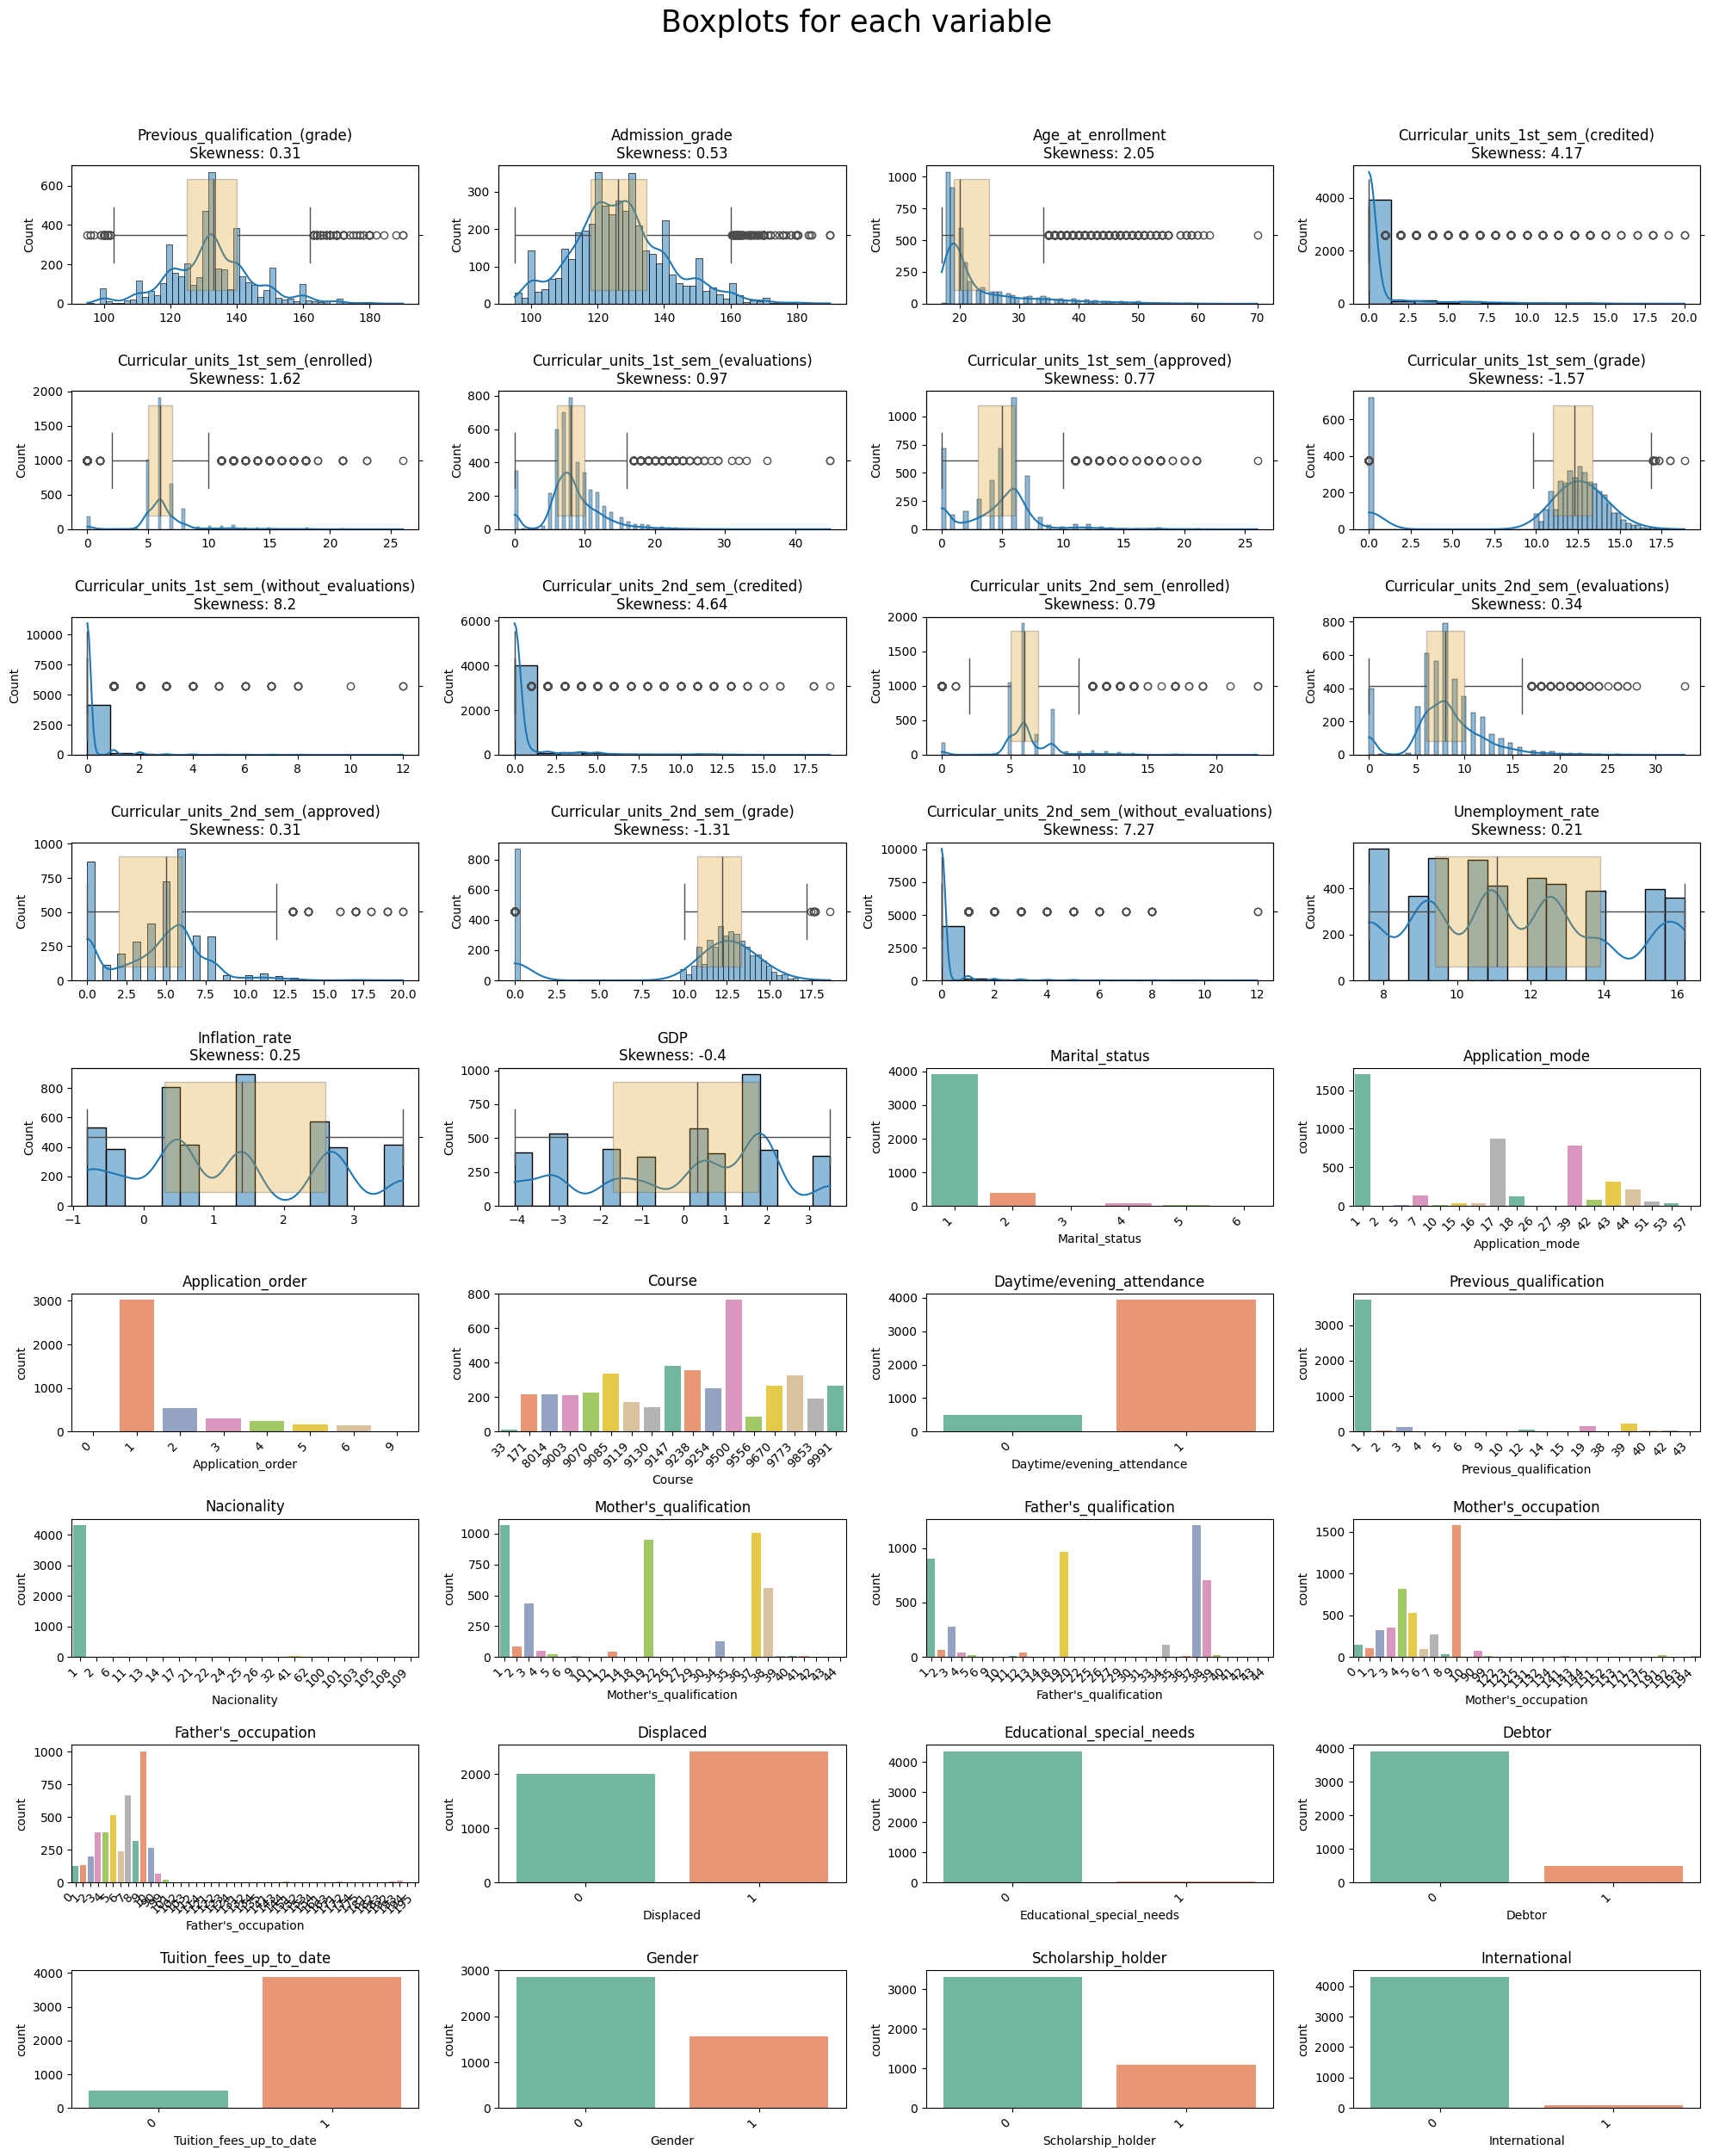

<Figure size 640x480 with 0 Axes>

In [11]:
plot_variables_custom(df=df, numeric_features=df_numeric_features, categorical_features=df_categorical_features, rows=9, cols=4, suptitle='Boxplots for each variable')
plt.tight_layout()

In [12]:
df = detect_and_handle_outliers(df, df_numeric_features)

Column 'Previous_qualification_(grade)': 13 outliers
Column 'Admission_grade': 5 outliers
Column 'Age_at_enrollment': 59 outliers
Column 'Curricular_units_1st_sem_(credited)': 108 outliers
Column 'Curricular_units_1st_sem_(enrolled)': 19 outliers
Column 'Curricular_units_1st_sem_(evaluations)': 11 outliers
Column 'Curricular_units_1st_sem_(approved)': 0 outliers
Column 'Curricular_units_1st_sem_(grade)': 0 outliers
Column 'Curricular_units_1st_sem_(without_evaluations)': 47 outliers
Column 'Curricular_units_2nd_sem_(credited)': 141 outliers
Column 'Curricular_units_2nd_sem_(enrolled)': 179 outliers
Column 'Curricular_units_2nd_sem_(evaluations)': 10 outliers
Column 'Curricular_units_2nd_sem_(approved)': 0 outliers
Column 'Curricular_units_2nd_sem_(grade)': 0 outliers
Column 'Curricular_units_2nd_sem_(without_evaluations)': 58 outliers
Column 'Unemployment_rate': 0 outliers
Column 'Inflation_rate': 0 outliers
Column 'GDP': 0 outliers


In [13]:
df

,Marital_status,Application_mode,Application_order,Course,Daytime/evening_attendance,Previous_qualification,Previous_qualification_(grade),Nacionality,Mother's_qualification,Father's_qualification,Mother's_occupation,Father's_occupation,Admission_grade,Displaced,Educational_special_needs,Debtor,Tuition_fees_up_to_date,Gender,Scholarship_holder,Age_at_enrollment,International,Curricular_units_1st_sem_(credited),Curricular_units_1st_sem_(enrolled),Curricular_units_1st_sem_(evaluations),Curricular_units_1st_sem_(approved),Curricular_units_1st_sem_(grade),Curricular_units_1st_sem_(without_evaluations),Curricular_units_2nd_sem_(credited),Curricular_units_2nd_sem_(enrolled),Curricular_units_2nd_sem_(evaluations),Curricular_units_2nd_sem_(approved),Curricular_units_2nd_sem_(grade),Curricular_units_2nd_sem_(without_evaluations),Unemployment_rate,Inflation_rate,GDP,Target
Fake_StudentID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
85167446C,1,15,1,9254,1,1,160.0,1,1,3,3,3,142.5,1,0,0,0,1,0,19.0,0,0,6,6,6,14.000000,0,0,6,6,6,13.666667,0,13.9,-0.3,0.79,0
14519294A,1,1,5,9070,1,1,122.0,1,37,37,9,9,124.8,1,0,0,0,1,0,19.0,0,0,6,0,0,0.000000,0,0,6,0,0,0.000000,0,10.8,1.4,1.74,1
89143675D,1,17,2,9773,1,1,122.0,1,38,37,5,3,119.6,1,0,0,1,0,0,20.0,0,0,6,8,6,13.428571,0,0,6,10,5,12.400000,0,9.4,-0.8,-3.12,0
57640183A,2,39,1,8014,0,1,100.0,1,37,38,9,9,141.5,0,0,0,1,0,0,45.0,0,0,6,9,5,12.333333,0,0,6,6,6,13.000000,0,13.9,-0.3,0.79,0
95500662C,1,1,1,9500,1,1,142.0,1,19,38,7,10,128.4,1,0,0,1,0,1,18.0,0,0,7,9,7,13.300000,0,0,8,8,8,14.345000,0,15.5,2.8,-4.06,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16311493D,1,44,1,9130,1,39,150.0,1,37,37,9,3,150.0,1,0,0,1,1,0,21.0,0,1,6,8,6,12.500000,0,0,6,11,3,13.333333,0,13.9,-0.3,0.79,1
56604212C,1,43,1,9070,1,1,125.0,1,19,19,7,8,133.4,1,0,0,1,1,1,19.0,0,4,6,6,4,13.000000,0,2,6,7,5,12.200000,0,13.9,-0.3,0.79,0
46473794C,1,43,1,33,1,1,143.0,1,37,1,9,10,121.2,1,0,0,1,1,0,25.0,0,5,10,13,5,11.600000,0,2,8,10,2,13.000000,0,12.4,0.5,1.79,0


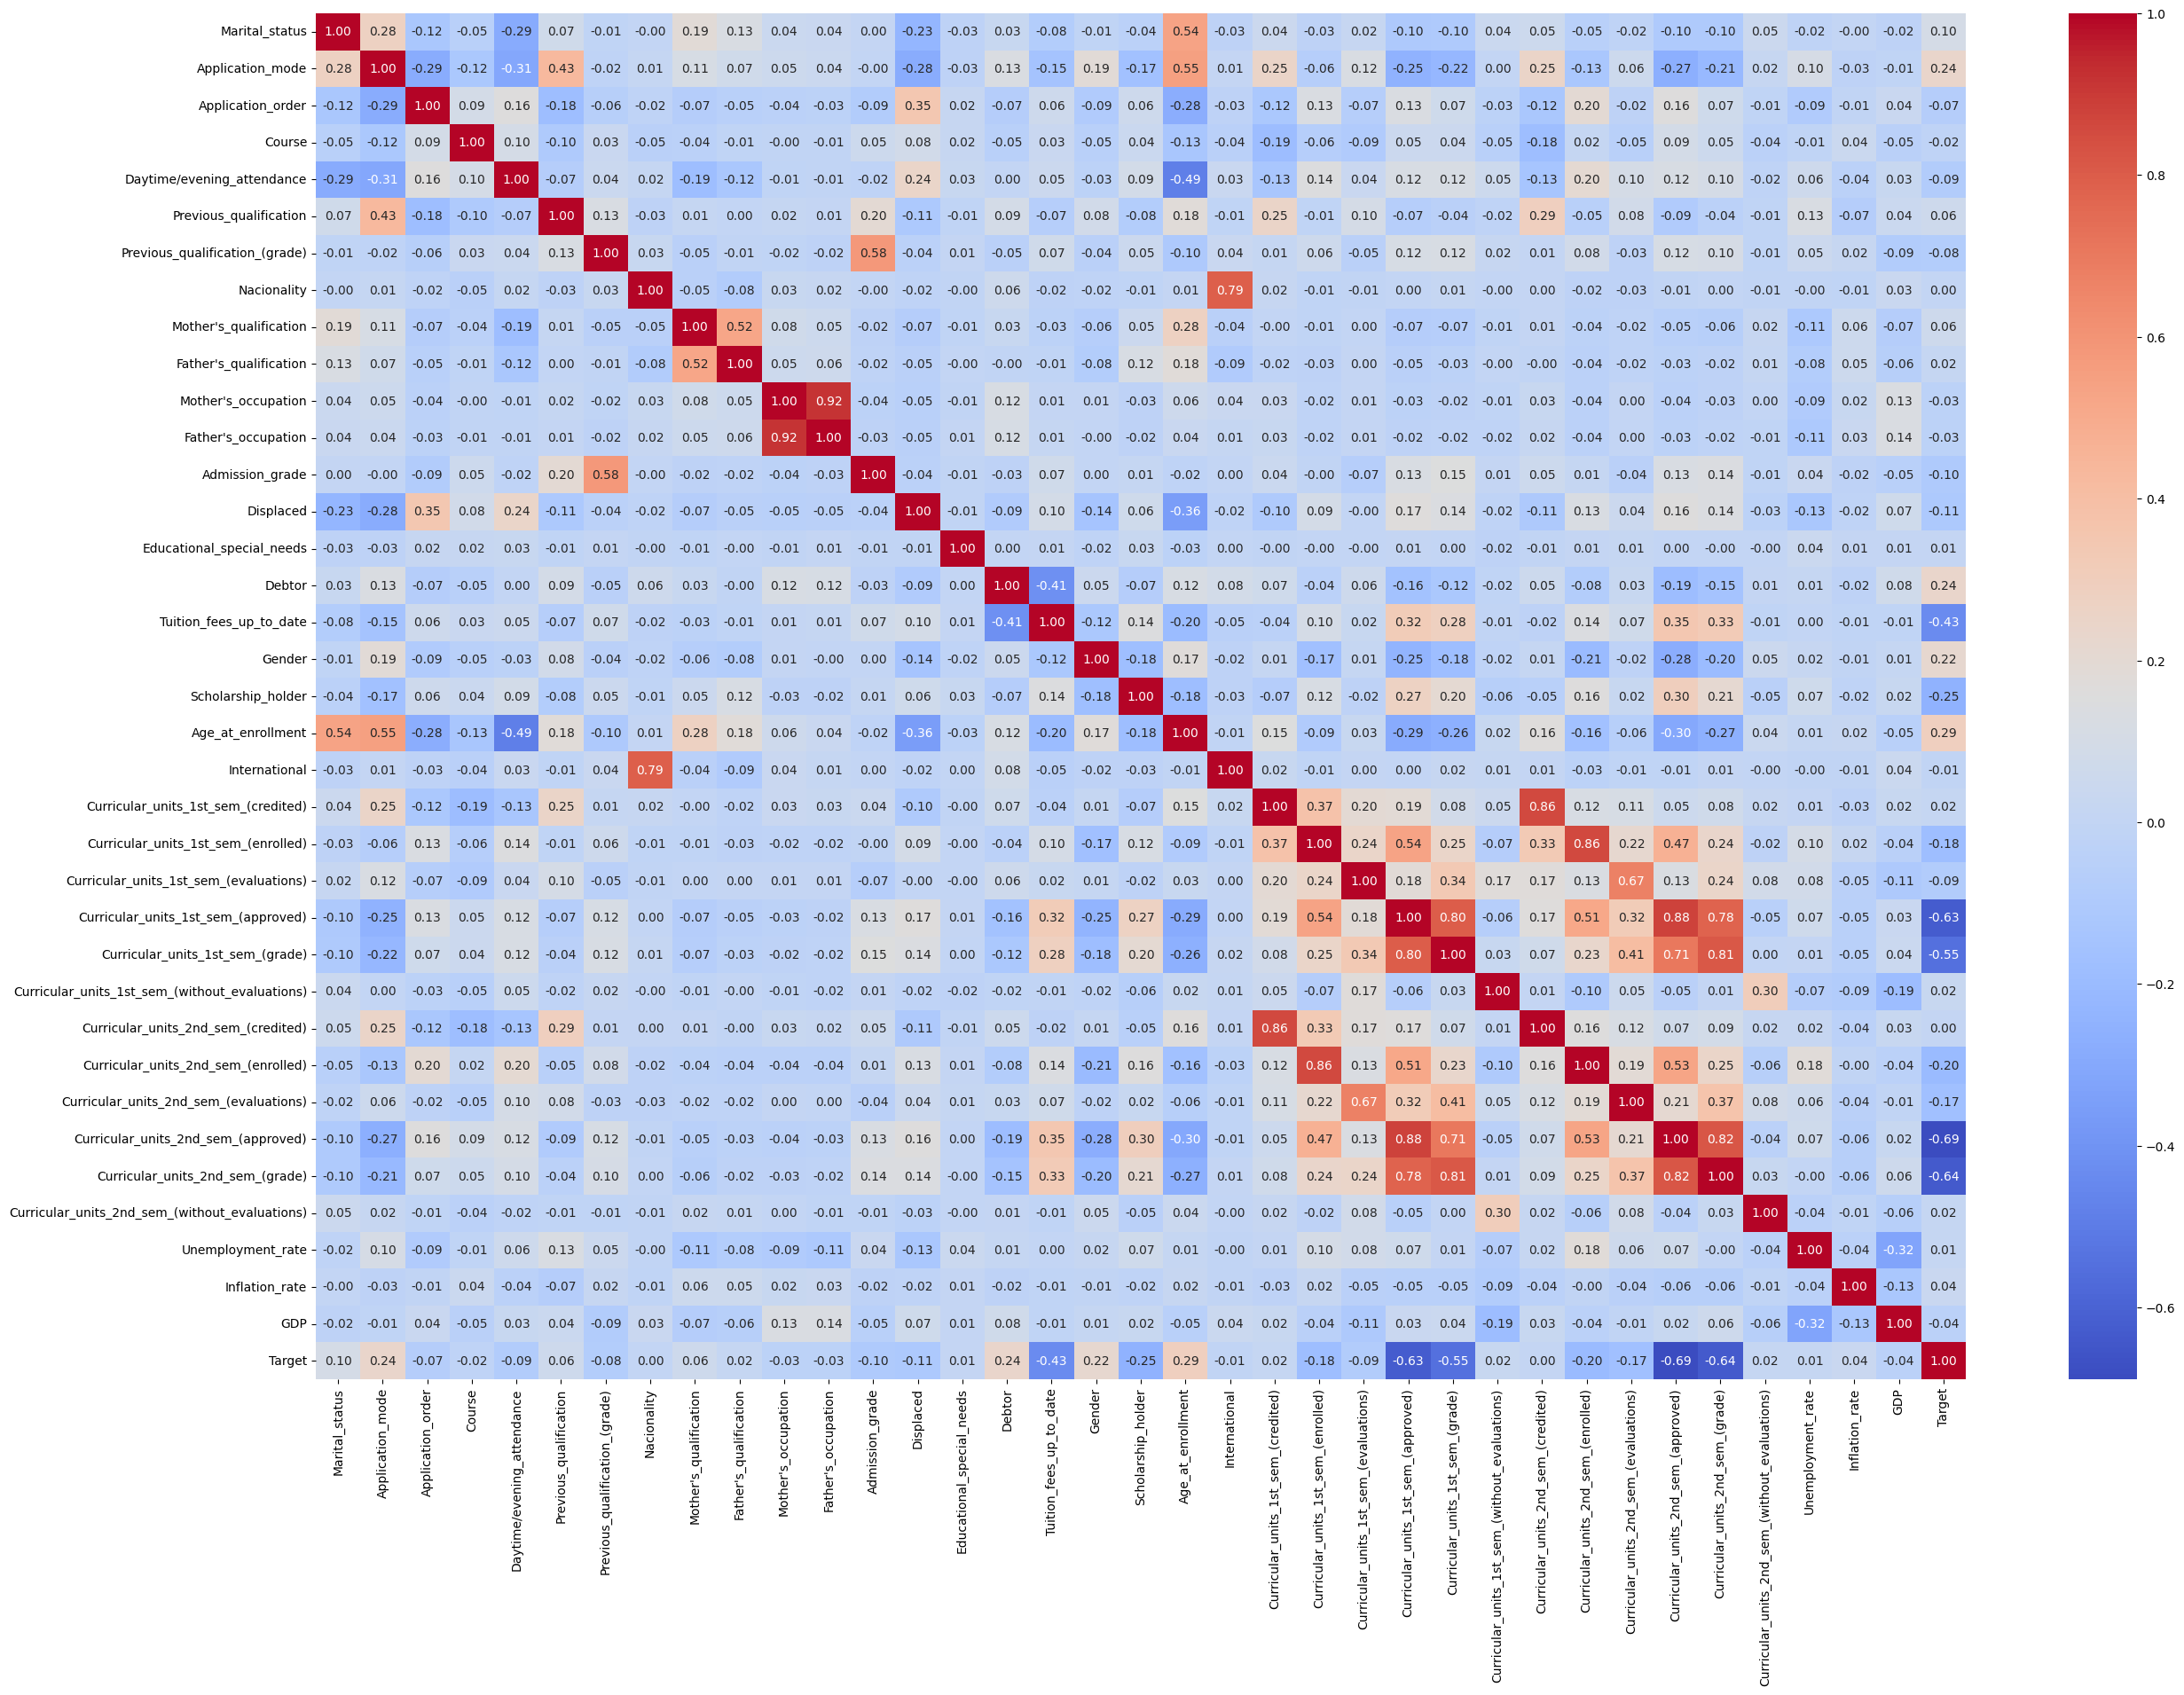

In [14]:
# Correlation matrix

plt.figure(figsize=(30, 20))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.show()

------------------------------------------------------------------------------
# Split train/test

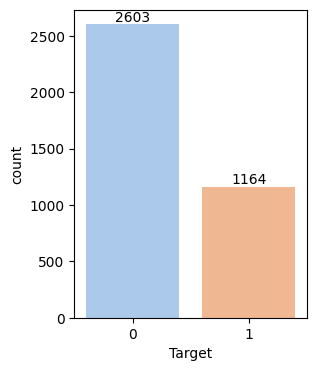

In [15]:
plt.figure(figsize=(3,4))
ax = sns.countplot(x='Target',data=df,palette="pastel")
for i in ax.containers:
    ax.bar_label(i,)

In [16]:
X = df.drop('Target', axis=1)
y = df['Target']

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, df['Target'], test_size=0.3, stratify=y)

---------------------------------------------------------------------------------------------
# Models

## Functions

In [18]:
# Function to calculate the F2 score (a weighted version of the F1 score, giving more importance to recall)

def f2_score(y_true, y_pred):
    return fbeta_score(y_true, y_pred, beta=2, zero_division=0)  # beta=2 prioritizes recall


# Custom precision score that avoids division by zero

def precision_score_no_zero(y_true, y_pred):
    return precision_score(y_true, y_pred, zero_division=0)  # Handles cases where precision may be undefined

model_evaluation_metrics = {
    'Accuracy': make_scorer(accuracy_score),  
    'Precision': make_scorer(precision_score_no_zero),  
    'Recall': make_scorer(recall_score),  
    'F2 Score': make_scorer(f2_score),  
    'AUC': make_scorer(roc_auc_score)  
}


In [19]:
# Function to create pipelines for model evaluation with different sampling techniques

def create_pipelines(model):
    return {
        # Pipeline using the original data without any sampling technique
        'Original': imbalanced_make_pipeline(steps=[['classifier', model]]), 

        # Pipeline using random under-sampling to balance the dataset by reducing the majority class
        'Under-sampled': imbalanced_make_pipeline(steps=[['under', RandomUnderSampler()], 
                                                         ['classifier', model]]),

        # Pipeline using SMOTE (Synthetic Minority Over-sampling Technique) to generate synthetic samples for the minority class
        'Over-sampled': imbalanced_make_pipeline(steps=[['over', SMOTE()], 
                                                        ['classifier', model]]),
    }


In [20]:
# Initialize Stratified K-Folds cross-validator to ensure each fold has the same proportion of classes
stratified_kfold = StratifiedKFold(n_splits=10, shuffle=True) 


# Function to create a grid search and fit the pipeline for model evaluation

def create_grid_and_fit_pipeline(pipeline, param_grid, X_train, y_train, model_evaluation_metrics, stratified_kfold):
    # Set up the grid search with the specified pipeline, parameter grid, and evaluation metrics
    grid_search = GridSearchCV(estimator=pipeline,
                                param_grid=param_grid,  # Hyperparameters to test
                                scoring=model_evaluation_metrics,  # Metrics for evaluation
                                cv=stratified_kfold,  # Cross-validation strategy
                                refit='F2 Score',  # Metric to refit the best model
                                n_jobs=-1)  # Use all available cores for computation
    
    # Fit the grid search to the training data
    grid_search.fit(X_train, y_train)

    return grid_search  # Return the fitted grid search object


In [21]:
# Function to evaluate classic models with various sampling techniques and hyperparameters using grid search

def evaluate_models(pipelines, param_grid, X_train, y_train, X_test, y_test, model_evaluation_metrics, stratified_kfold):
    results = {}  # Dictionary to store evaluation results for each model
    best_model = None  # Placeholder for the best model found
    best_metric = -float('inf')  # Initialize the best metric as negative infinity
            
    # Loop through each pipeline (model) for evaluation
    for name, pipeline in pipelines.items():
        print(f"Evaluating {name}...")  # Print the current model being evaluated
        
        # Create and fit the grid search pipeline
        grid_search = create_grid_and_fit_pipeline(pipeline, param_grid, X_train, y_train, model_evaluation_metrics, stratified_kfold)

        # Store the evaluation results from cross-validation
        results[name] = {
            'Accuracy': grid_search.cv_results_['mean_test_Accuracy'][grid_search.best_index_],
            'Precision': grid_search.cv_results_['mean_test_Precision'][grid_search.best_index_],
            'Recall': grid_search.cv_results_['mean_test_Recall'][grid_search.best_index_],
            'F2 Score': grid_search.cv_results_['mean_test_F2 Score'][grid_search.best_index_],
            'AUC': grid_search.cv_results_['mean_test_AUC'][grid_search.best_index_]
        }
        
        # Get the best estimator (model) from the grid search
        best_model_candidate = grid_search.best_estimator_
        # Predict labels for the test set
        y_pred_test = best_model_candidate.predict(X_test)
        # Predict probabilities for the test set
        y_proba_test = best_model_candidate.predict_proba(X_test)[:, 1] 
        
        # Evaluate the best model on the test set
        results[name]['Test Accuracy'] = accuracy_score(y_test, y_pred_test)
        results[name]['Test Precision'] = precision_score_no_zero(y_test, y_pred_test)
        results[name]['Test Recall'] = recall_score(y_test, y_pred_test)
        results[name]['Test F2 Score'] = f2_score(y_test, y_pred_test)
        results[name]['Test AUC'] = roc_auc_score(y_test, y_proba_test)

        # Check if the current model's F2 score is the best found
        if results[name]['Test F2 Score'] > best_metric:
            best_metric = results[name]['Test F2 Score']  # Update the best metric
            best_model = best_model_candidate  # Update the best model
        
    return results, best_model  # Return the evaluation results and the best model


In [22]:
# Function to evaluate AutoGluon models

def evaluate_autogluon(label, X_train, y_train, X_test, y_test, eval_metric=ag_make_scorer(name='f2', score_func=f2_score)):
    results = {}  # Dictionary to store evaluation results
    train_data_dict = {}  # Dictionary to hold different training datasets
    trained_predictors = []  # List to keep track of trained predictors
    best_model = None  # Placeholder for the best model found
    best_metric = -float('inf')  # Initialize the best metric as negative infinity

    # Perform under-sampling and over-sampling on training data
    under_X_train, under_y_train = RandomUnderSampler().fit_resample(X_train, y_train)
    over_X_train, over_y_train = SMOTE().fit_resample(X_train, y_train)

    # Prepare the datasets for AutoGluon
    original_train_data = TabularDataset(X_train.join(y_train))
    under_train_data = TabularDataset(under_X_train.join(under_y_train))
    over_train_data = TabularDataset(over_X_train.join(over_y_train))
    test_data = TabularDataset(X_test.join(y_test))  # Prepare test dataset

    # Store different training datasets in a dictionary
    train_data_dict = {
        'Original': original_train_data,
        'Under-sampled': under_train_data,
        'Over-sampled': over_train_data
    }
    
    # Loop through each training dataset and evaluate
    for name, train_data in train_data_dict.items():
        print(f"Evaluating {name} with AutoGluon...")  # Indicate which dataset is being evaluated
        predictor = TabularPredictor(label=label, eval_metric=eval_metric)  # Initialize AutoGluon predictor
        trained_predictor = predictor.fit(train_data, presets='best_quality', time_limit=3600, verbosity=0)  # Fit the model
        trained_predictors.append(trained_predictor)  # Save the trained predictor

        # Make predictions on the test data
        y_pred = trained_predictor.predict(test_data.drop(columns=[label]))
        y_proba = trained_predictor.predict_proba(test_data.drop(columns=[label]))[1]

        # Store evaluation metrics for the current model
        results[name] = {
            'Test Accuracy': accuracy_score(y_test, y_pred),
            'Test Precision': precision_score_no_zero(y_test, y_pred),
            'Test Recall': recall_score(y_test, y_pred),
            'Test F2 Score': fbeta_score(y_test, y_pred, beta=2),
            'Test AUC': roc_auc_score(y_test, y_proba)
        }

        # Check if the current model's F2 score is the best found
        if results[name]['Test F2 Score'] > best_metric:
            best_metric = results[name]['Test F2 Score']  # Update the best metric
            best_model = trained_predictor  # Update the best model

    return results, best_model, trained_predictors  # Return the evaluation results, best model, and trained predictors


### Gradient Boost

In [236]:
gradient_boost_param_grid = {
    'classifier__n_estimators':[10, 100, 1000],
    'classifier__max_depth':[1, 10, 100],
    'classifier__learning_rate':[0.001, 0.01, 0.1],
}

In [237]:
gradient_boost = GradientBoostingClassifier()
gradient_boost_pipelines = create_pipelines(gradient_boost)

In [239]:
gradient_boost_results, gradient_boost_best_model = evaluate_models(pipelines=gradient_boost_pipelines, param_grid=gradient_boost_param_grid, X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test, model_evaluation_metrics=model_evaluation_metrics, stratified_kfold=stratified_kfold)

Evaluating Original...
Evaluating Under-sampled...
Evaluating Over-sampled...


In [240]:
gradient_boost_results

{'Original': {'Accuracy': 0.8937881668394978,
  'Precision': 0.8733010181895888,
  'Recall': 0.770505871725384,
  'F2 Score': 0.788526174911579,
  'AUC': 0.8597154951613168,
  'Test Accuracy': 0.8894783377541998,
  'Test Precision': 0.856687898089172,
  'Test Recall': 0.7707736389684814,
  'Test F2 Score': 0.7865497076023392,
  'Test AUC': 0.9228339647806301},
 'Under-sampled': {'Accuracy': 0.8778473902523333,
  'Precision': 0.7840506024670464,
  'Recall': 0.8367359229147848,
  'F2 Score': 0.8252323093199966,
  'AUC': 0.8664689042304662,
  'Test Accuracy': 0.865605658709107,
  'Test Precision': 0.7585301837270341,
  'Test Recall': 0.828080229226361,
  'Test F2 Score': 0.8131682611142375,
  'Test AUC': 0.918719175723111},
 'Over-sampled': {'Accuracy': 0.8714079963129393,
  'Precision': 0.7857447351259362,
  'Recall': 0.8025745257452573,
  'F2 Score': 0.7988051828370948,
  'AUC': 0.8524161885917184,
  'Test Accuracy': 0.8647214854111406,
  'Test Precision': 0.76775956284153,
  'Test Reca

In [241]:
gradient_boost_best_model

Pipeline(steps=[('under', RandomUnderSampler()),
                ['classifier',
                 GradientBoostingClassifier(max_depth=1, n_estimators=1000)]])

### Random Forest

In [242]:
random_forest_param_grid = {
    'classifier__n_estimators':[10, 100, 1000],
    'classifier__max_depth':[1, 10, 100],
}

In [243]:
random_forest = RandomForestClassifier()
random_forest_pipelines = create_pipelines(random_forest)

In [244]:
random_forest_results, random_forest_best_model = evaluate_models(pipelines=random_forest_pipelines, param_grid=random_forest_param_grid, X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test, model_evaluation_metrics=model_evaluation_metrics, stratified_kfold=stratified_kfold)

Evaluating Original...
Evaluating Under-sampled...
Evaluating Over-sampled...


In [245]:
random_forest_results

{'Original': {'Accuracy': 0.8877304412950802,
  'Precision': 0.8753462343968433,
  'Recall': 0.7449864498644987,
  'F2 Score': 0.7668252838762021,
  'AUC': 0.8483294106045005,
  'Test Accuracy': 0.8894783377541998,
  'Test Precision': 0.8660130718954249,
  'Test Recall': 0.7593123209169055,
  'Test F2 Score': 0.7784958871915394,
  'Test AUC': 0.9234989996995435},
 'Under-sampled': {'Accuracy': 0.8763163958981449,
  'Precision': 0.7796899530299899,
  'Recall': 0.8378048780487806,
  'F2 Score': 0.8248643206165299,
  'AUC': 0.8656327578858566,
  'Test Accuracy': 0.8647214854111406,
  'Test Precision': 0.7592592592592593,
  'Test Recall': 0.8223495702005731,
  'Test F2 Score': 0.8089064261555806,
  'Test AUC': 0.9221707619138348},
 'Over-sampled': {'Accuracy': 0.8877117179398549,
  'Precision': 0.8382957650152854,
  'Recall': 0.7913881361035833,
  'F2 Score': 0.7999786705458777,
  'AUC': 0.8610981994395296,
  'Test Accuracy': 0.874447391688771,
  'Test Precision': 0.8053097345132744,
  'Te

In [246]:
random_forest_best_model

Pipeline(steps=[('under', RandomUnderSampler()),
                ['classifier',
                 RandomForestClassifier(max_depth=100, n_estimators=1000)]])

### XGBClassifier

In [247]:
xgbclassifier_param_grid = {
    'classifier__n_estimators':[10, 100, 1000],
    'classifier__max_depth':[1, 10, 100],
    'classifier__learning_rate':[0.001, 0.01, 0.1],
}

In [248]:
xgbclassifier = XGBClassifier()
xgbclassifier_pipelines = create_pipelines(xgbclassifier)

In [249]:
xgbclassifier_results, xgbclassifier_best_model = evaluate_models(pipelines=xgbclassifier_pipelines, param_grid=xgbclassifier_param_grid, X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test, model_evaluation_metrics=model_evaluation_metrics, stratified_kfold=stratified_kfold)

Evaluating Original...
Evaluating Under-sampled...
Evaluating Over-sampled...


In [250]:
xgbclassifier_results

{'Original': {'Accuracy': 0.8968011867726696,
  'Precision': 0.8806562231098896,
  'Recall': 0.7730201746461909,
  'F2 Score': 0.7917359960276846,
  'AUC': 0.8626179958080531,
  'Test Accuracy': 0.8894783377541998,
  'Test Precision': 0.8589743589743589,
  'Test Recall': 0.7679083094555874,
  'Test F2 Score': 0.7845433255269321,
  'Test AUC': 0.9257835686909622},
 'Under-sampled': {'Accuracy': 0.8679758612743405,
  'Precision': 0.7601442320235086,
  'Recall': 0.8369015356820235,
  'F2 Score': 0.8200791140039284,
  'AUC': 0.859410354702238,
  'Test Accuracy': 0.8558797524314765,
  'Test Precision': 0.7360406091370558,
  'Test Recall': 0.830945558739255,
  'Test F2 Score': 0.8100558659217877,
  'Test AUC': 0.918184216504591},
 'Over-sampled': {'Accuracy': 0.875184353036064,
  'Precision': 0.7966745600459668,
  'Recall': 0.8047576031315868,
  'F2 Score': 0.8025345916198907,
  'AUC': 0.8557160380997513,
  'Test Accuracy': 0.8620689655172413,
  'Test Precision': 0.7615176151761518,
  'Test 

In [251]:
xgbclassifier_best_model

Pipeline(steps=[('under', RandomUnderSampler()),
                ['classifier',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None, device=None,
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_metric=None,
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=0.1,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=10, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=100, n_jobs=None,
                               num_parallel_tree=None, random_state=None, ...)]])

### Autogluon

In [23]:
test_data = TabularDataset(X_test.join(y_test))

In [ ]:
autogluon_results, autogluon_best_model, all_autogluon_models = evaluate_autogluon(label="Target", X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test)

In [83]:
autogluon_results

{'Original': {'Test Accuracy': 0.8850574712643678,
  'Test Precision': 0.8411214953271028,
  'Test Recall': 0.7736389684813754,
  'Test F2 Score': 0.786255096097845,
  'Test AUC': 0.9259979187887937},
 'Under-sampled': {'Test Accuracy': 0.8868258178603006,
  'Test Precision': 0.7994579945799458,
  'Test Recall': 0.8452722063037249,
  'Test F2 Score': 0.8356940509915014,
  'Test AUC': 0.932510864069061},
 'Over-sampled': {'Test Accuracy': 0.874447391688771,
  'Test Precision': 0.8461538461538461,
  'Test Recall': 0.7249283667621776,
  'Test F2 Score': 0.7463126843657817,
  'Test AUC': 0.898845074344675}}

## Compare models

In [258]:
# Function to create a DataFrame with the evaluation results for all models (except AutoGluon)

def create_model_metrics_df(dataset_name, gradient_boost_results, random_forest_results, xgb_results):
    index_list = []  # List to hold the index tuples for the DataFrame
    results_dict = {'Gradient Boost': [], 'Random Forest': [], 'XGBClassifier': []}  # Dictionary to store results for each model
    sample_types = ['Original', 'Under-sampled', 'Over-sampled']  # Different sampling methods to evaluate

    # Helper function to add test results to the results dictionary
    def add_test_results_to_dict(model_results, model_name, sample_types_to_use):
        for sampling_type in sample_types_to_use:
            if sampling_type in model_results:  # Check if the sampling type exists in the model results
                metrics = model_results[sampling_type]
                for metric, value in metrics.items():
                    if "Test" in metric:  # Focus on test metrics
                        if len(results_dict[model_name]) == len(index_list):
                            index_list.append((dataset_name, sampling_type, metric))  # Append index tuple if sizes match
                        results_dict[model_name].append(value)  # Store the metric value

            else:  # If the sampling type does not exist in the results
                for metric in metrics.keys():
                    if "Test" in metric:  # Again, focus on test metrics
                        if len(results_dict[model_name]) == len(index_list):
                            index_list.append((dataset_name, sampling_type, metric))  # Append index tuple if sizes match
                        results_dict[model_name].append(np.nan)  # Use NaN for missing values

    # Add results for each model to the dictionary
    add_test_results_to_dict(gradient_boost_results, 'Gradient Boost', sample_types)
    add_test_results_to_dict(random_forest_results, 'Random Forest', sample_types)
    add_test_results_to_dict(xgb_results, 'XGBClassifier', sample_types)

    # Create a DataFrame using the results dictionary and the multi-index
    df = pd.DataFrame(results_dict, index=pd.MultiIndex.from_tuples(index_list, names=["Dataset", "Type", "Metric"]))
    return df  # Return the resulting DataFrame


In [259]:
df_metrics = create_model_metrics_df('df', gradient_boost_results, random_forest_results, xgbclassifier_results)

In [260]:
# Metrics of each classic model evaluated

df_metrics

Gradient Boost  Random Forest  \
Dataset Type          Metric                                          
df      Original      Test Accuracy         0.889478       0.889478   
                      Test Precision        0.856688       0.866013   
                      Test Recall           0.770774       0.759312   
                      Test F2 Score         0.786550       0.778496   
                      Test AUC              0.922834       0.923499   
        Under-sampled Test Accuracy         0.865606       0.864721   
                      Test Precision        0.758530       0.759259   
                      Test Recall           0.828080       0.822350   
                      Test F2 Score         0.813168       0.808906   
                      Test AUC              0.918719       0.922171   
        Over-sampled  Test Accuracy         0.864721       0.874447   
                      Test Precision        0.767760       0.805310   
                      Test Recall           0.805158       0.782235   
                      Test F2 Score         0.797389       0.786744   
                      Test AUC              0.920040       0.923900   

                                      XGBClassifier  
Dataset Type          Metric                         
df      Original      Test Accuracy        0.889478  
                      Test Precision       0.858974  
                      Test Recall          0.767908  
                      Test F2 Score        0.784543  
                      Test AUC             0.925784  
        Under-sampled Test Accuracy        0.855880  
                      Test Precision       0.736041  
                      Test Recall          0.830946  
                      Test F2 Score        0.810056  
                      Test AUC             0.918184  
        Over-sampled  Test Accuracy        0.862069  
                      Test Precision       0.761518  
                      Test Recall          0.805158  
                      Test F2 Score        0.796034  
                      Test AUC             0.919604

# Load the model

In [28]:
#Load already created model

autogluon_original_model = TabularPredictor.load('/home/alberto/TFM/AutogluonModels/ag-20240830_223330')
autogluon_undersample_model = TabularPredictor.load('/home/alberto/TFM/AutogluonModels/ag-20240830_224933')
autogluon_oversample_model = TabularPredictor.load('/home/alberto/TFM/AutogluonModels/ag-20240830_230355')

In [31]:
# Autogluon with original dataset
autogluon_original_model.leaderboard(test_data, extra_metrics=['accuracy', 'precision', 'recall', 'roc_auc'])

,model,score_test,accuracy,precision,recall,roc_auc,score_val,eval_metric,pred_time_test,pred_time_val,fit_time,pred_time_test_marginal,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
0,RandomForest_r127_BAG_L2,0.942529,0.967286,0.953488,0.939828,0.981024,0.773390,f2,2.028248,1.828428,11.925620,0.092072,0.086222,0.777586,2,True,31
1,RandomForest_r15_BAG_L2,0.940736,0.967286,0.956140,0.936963,0.980283,0.774169,f2,2.031912,1.831062,11.906569,0.095736,0.088856,0.758536,2,True,36
2,ExtraTrees_r197_BAG_L2,0.935521,0.964633,0.953079,0.931232,0.981463,0.777834,f2,2.038710,1.832407,11.777860,0.102534,0.090200,0.629827,2,True,37
3,RandomForest_r166_BAG_L2,0.935521,0.964633,0.953079,0.931232,0.980969,0.777358,f2,2.041940,1.834135,11.787281,0.105764,0.091929,0.639248,2,True,35
4,RandomForest_r34_BAG_L2,0.934256,0.965517,0.958580,0.928367,0.984911,0.777750,f2,2.024300,1.826284,11.806491,0.088124,0.084078,0.658458,2,True,32
5,RandomForestGini_BAG_L2,0.933718,0.964633,0.955752,0.928367,0.981198,0.770393,f2,2.051239,1.833239,11.721094,0.115062,0.091033,0.573061,2,True,22
6,RandomForestEntr_BAG_L2,0.933718,0.964633,0.955752,0.928367,0.982255,0.765255,f2,2.059275,1.830425,11.721807,0.123099,0.088218,0.573774,2,True,23
7,ExtraTrees_r178_BAG_L2,0.933180,0.963749,0.952941,0.928367,0.983625,0.776882,f2,2.033455,1.830020,11.750366,0.097279,0.087814,0.602333,2,True,34
8,RandomForest_r39_BAG_L2,0.932642,0.962865,0.950147,0.928367,0.979756,0.782074,f2,2.035001,1.829930,11.884605,0.098825,0.087723,0.736572,2,True,29
9,WeightedEnsemble_L3,0.932642,0.962865,0.950147,0.928367,0.979756,0.782074,f2,2.037295,1.831928,12.361513,0.002294,0.001998,0.476908,3,True,40


In [32]:
# Autogluon with undersampled dataset
autogluon_undersample_model.leaderboard(test_data, extra_metrics=['accuracy', 'precision', 'recall', 'roc_auc'])

,model,score_test,accuracy,precision,recall,roc_auc,score_val,eval_metric,pred_time_test,pred_time_val,fit_time,pred_time_test_marginal,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
0,ExtraTreesEntr_BAG_L1,0.936801,0.937224,0.854592,0.959885,0.981546,0.829158,f2,0.118747,0.075305,0.530845,0.118747,0.075305,0.530845,1,True,6
1,ExtraTrees_r42_BAG_L2,0.935050,0.937224,0.856410,0.957020,0.967571,0.836037,f2,1.987026,1.387716,11.133786,0.110576,0.075383,0.555838,2,True,26
2,RandomForestEntr_BAG_L1,0.934527,0.936340,0.854220,0.957020,0.979739,0.840818,f2,0.104127,0.076123,0.574702,0.104127,0.076123,0.574702,1,True,4
3,WeightedEnsemble_L2,0.934527,0.936340,0.854220,0.957020,0.980481,0.848070,f2,0.334721,0.224495,2.042373,0.002643,0.001725,0.377552,2,True,21
4,RandomForest_r166_BAG_L2,0.934527,0.936340,0.854220,0.957020,0.968108,0.840410,f2,1.973755,1.385216,11.183489,0.097305,0.072883,0.605541,2,True,35
5,RandomForestGini_BAG_L1,0.934372,0.930150,0.835821,0.962751,0.979673,0.831671,f2,0.104680,0.075745,0.569440,0.104680,0.075745,0.569440,1,True,3
6,ExtraTreesGini_BAG_L1,0.934004,0.935455,0.852041,0.957020,0.981209,0.836878,f2,0.117707,0.075053,0.547052,0.117707,0.075053,0.547052,1,True,5
7,ExtraTrees_r49_BAG_L1,0.934004,0.935455,0.852041,0.957020,0.981209,0.836878,f2,0.120816,0.074067,0.572645,0.120816,0.074067,0.572645,1,True,11
8,ExtraTrees_r4_BAG_L2,0.934004,0.935455,0.852041,0.957020,0.974241,0.842486,f2,1.963166,1.380777,11.164725,0.086717,0.068444,0.586777,2,True,33
9,RandomForest_r15_BAG_L2,0.934004,0.935455,0.852041,0.957020,0.965510,0.835415,f2,1.966038,1.383378,11.222567,0.089589,0.071045,0.644619,2,True,36


In [33]:
# Autogluon with SMOTE
autogluon_oversample_model.leaderboard(test_data, extra_metrics=['accuracy', 'precision', 'recall', 'roc_auc'])

,model,score_test,accuracy,precision,recall,roc_auc,score_val,eval_metric,pred_time_test,pred_time_val,fit_time,pred_time_test_marginal,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
0,ExtraTrees_r49_BAG_L1,0.950200,0.968170,0.945869,0.951289,0.990006,0.900587,f2,0.122738,0.106525,0.604184,0.122738,0.106525,0.604184,1,True,11
1,ExtraTreesGini_BAG_L1,0.950200,0.968170,0.945869,0.951289,0.990006,0.900587,f2,0.142817,0.105556,0.576179,0.142817,0.105556,0.576179,1,True,5
2,RandomForest_r166_BAG_L1,0.946644,0.968170,0.951009,0.945559,0.990153,0.901885,f2,0.113330,0.099170,0.618818,0.113330,0.099170,0.618818,1,True,16
3,ExtraTreesEntr_BAG_L1,0.945017,0.965517,0.942857,0.945559,0.989651,0.901494,f2,0.120040,0.105078,0.598196,0.120040,0.105078,0.598196,1,True,6
4,ExtraTrees_r42_BAG_L1,0.944476,0.964633,0.940171,0.945559,0.987604,0.898541,f2,0.109301,0.097320,0.604015,0.109301,0.097320,0.604015,1,True,7
5,ExtraTrees_r126_BAG_L2,0.942529,0.967286,0.953488,0.939828,0.988733,0.921372,f2,2.080219,1.909487,11.984964,0.104627,0.100865,0.609815,2,True,39
6,ExtraTrees_r197_BAG_L1,0.942153,0.963749,0.940000,0.942693,0.986600,0.901359,f2,0.107443,0.098636,0.626157,0.107443,0.098636,0.626157,1,True,18
7,RandomForestEntr_BAG_L1,0.941987,0.966401,0.950725,0.939828,0.990532,0.898858,f2,0.118227,0.099874,0.579018,0.118227,0.099874,0.579018,1,True,4
8,RandomForestGini_BAG_L1,0.941987,0.966401,0.950725,0.939828,0.990338,0.899368,f2,0.121044,0.099948,0.589553,0.121044,0.099948,0.589553,1,True,3
9,ExtraTrees_r4_BAG_L2,0.941987,0.966401,0.950725,0.939828,0.989872,0.924111,f2,2.814585,1.911459,11.969237,0.838994,0.102838,0.594089,2,True,33


In [29]:
model = autogluon_original_model._trainer.load_model('RandomForestEntr_BAG_L1')

test_data = TabularDataset(X_test.join(y_test))
predictions = model.predict(test_data.drop(columns=['Target']))

# DiCE

In [23]:
# Indicate which variables can be modified by the counterfactuals. To make the counterfactuals plausibles, only logical variables can be modified.

features_to_not_vary = ["Marital_status", "Course", "Nacionality", "Mother's_qualification", "Father's_qualification", "Mother's_occupation", "Father's_occupation", "Gender", "Age_at_enrollment", "Target"]
features_to_vary = [col for col in df.columns if col not in features_to_not_vary]

In [30]:
#Create DiCE explainer for generating individual counterfactuals

d = dice_ml.Data(dataframe=df,
                 continuous_features=df_numeric_features,
                 outcome_name='Target')

m = dice_ml.Model(model=model, backend="sklearn")

exp = dice_ml.Dice(d,m)

In [32]:
# Test counterfactuals

queries = X_test[y_test == 1].sample(1)
counterfactuals = exp.generate_counterfactuals(queries, total_CFs=3, desired_class=0, features_to_vary=features_to_vary)
counterfactuals.visualize_as_dataframe(show_only_changes=True)

predictions_proba = model.predict_proba(queries)
    
print(predictions_proba)

100%|██████████| 1/1 [00:01<00:00,  1.33s/it]

Query instance (original outcome : 1)


,Marital_status,Application_mode,Application_order,Course,Daytime/evening_attendance,Previous_qualification,Previous_qualification_(grade),Nacionality,Mother's_qualification,Father's_qualification,Mother's_occupation,Father's_occupation,Admission_grade,Displaced,Educational_special_needs,Debtor,Tuition_fees_up_to_date,Gender,Scholarship_holder,Age_at_enrollment,International,Curricular_units_1st_sem_(credited),Curricular_units_1st_sem_(enrolled),Curricular_units_1st_sem_(evaluations),Curricular_units_1st_sem_(approved),Curricular_units_1st_sem_(grade),Curricular_units_1st_sem_(without_evaluations),Curricular_units_2nd_sem_(credited),Curricular_units_2nd_sem_(enrolled),Curricular_units_2nd_sem_(evaluations),Curricular_units_2nd_sem_(approved),Curricular_units_2nd_sem_(grade),Curricular_units_2nd_sem_(without_evaluations),Unemployment_rate,Inflation_rate,GDP,Target
0,2,39,1,9991,0,9,133.100006,1,34,34,0,0,118.400002,0,0,0,0,0,0,39.0,0,0,5,5,0,0.0,0,0,5,5,0,0.0,0,7.6,2.6,0.32,1



Diverse Counterfactual set (new outcome: 0)


,Marital_status,Application_mode,Application_order,Course,Daytime/evening_attendance,Previous_qualification,Previous_qualification_(grade),Nacionality,Mother's_qualification,Father's_qualification,Mother's_occupation,Father's_occupation,Admission_grade,Displaced,Educational_special_needs,Debtor,Tuition_fees_up_to_date,Gender,Scholarship_holder,Age_at_enrollment,International,Curricular_units_1st_sem_(credited),Curricular_units_1st_sem_(enrolled),Curricular_units_1st_sem_(evaluations),Curricular_units_1st_sem_(approved),Curricular_units_1st_sem_(grade),Curricular_units_1st_sem_(without_evaluations),Curricular_units_2nd_sem_(credited),Curricular_units_2nd_sem_(enrolled),Curricular_units_2nd_sem_(evaluations),Curricular_units_2nd_sem_(approved),Curricular_units_2nd_sem_(grade),Curricular_units_2nd_sem_(without_evaluations),Unemployment_rate,Inflation_rate,GDP,Target
0,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,1.0,-,-,-,-,-,1.0,-,-,17.8,-,1.0,-,-,7.0,8.5,-,-,-,-,0.0
1,-,-,-,-,-,-,123.0,-,-,-,-,-,-,-,-,-,1.0,-,-,-,-,-,-,-,6.0,13.3,-,-,-,19.0,5.0,-,-,-,-,-,0.0
2,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,1.0,-,-,-,1.0,-,-,-,6.0,-,-,-,-,-,8.0,12.1,-,-,-,-,0.0


[0.9866667]


# Group counterfactual generator algorithm with KNN

In [33]:
negative_outcome = [y_train.iloc[instance] for instance in np.where(predictions == 1)][0] # students who dont pass in the test set
positive_outcome = [y_train.iloc[instance] for instance in np.where(predictions == 0)][0] # students who pass in the test set

positive_train_set = [X_train.iloc[instance] for instance in np.where(predictions == 0)][0] # students who pass in the train set
negative_train_set = positive = [X_train.iloc[instance] for instance in np.where(predictions == 1)][0] # students who dont pass in the train set

In [34]:
if type(model) is keras.src.models.sequential.Sequential:
    positive_train_indices = sorted(set(np.where(y_train==0)[0]).intersection(set(np.where(model.predict(X_train).round().reshape(-1) == y_train)[0]))) # students who pass in the train set and are correctly classified
    negative_train_set_indices = sorted(set(np.where(y_train==1)[0]).intersection(set(np.where(model.predict(X_train).round().reshape(-1) == y_train)[0]))) # students who dont pass in the train set and are correctly classified

else:
    positive_train_indices = sorted(set(np.where(y_train==0)[0]).intersection(set(np.where(model.predict(X_train) == y_train)[0]))) # students who pass in the train set and are correctly classified
    negative_train_set_indices = sorted(set(np.where(y_train==1)[0]).intersection(set(np.where(model.predict(X_train) == y_train)[0]))) # students who dont pass in the train set and are correctly classified

positive_train_set = X_train.iloc[positive_train_indices] # students who pass in the train set and are correctly classified
negative_train_set = X_train.iloc[negative_train_set_indices] # students who dont pass in the train set and are correctly classified

In [35]:
N_NEIGHBORS = 5

neighbors_negative = NearestNeighbors(n_neighbors=N_NEIGHBORS, metric='hamming').fit(negative_train_set) # fit the nearest neighbors model with the negative train set
neighbors_positive = NearestNeighbors(n_neighbors=N_NEIGHBORS, metric='hamming').fit(positive_train_set) # fit the nearest neighbors model with the positive train set

## Functions

In [36]:
# This function finds the nearest unlike neighbor (NUN) of a query instance

def NUN_finder(row, outcome, neighbors_negative, neighbors_positive, negative_train_set, positive_train_set):
    if outcome not in ['negative', 'positive']:
        raise ValueError("Outcome must be 'negative' or 'positive'")
    
    row_reshaped = row.reshape(1, -1)
    
    # Find the nearest unlike neighbors of the query instance
    if outcome == 'negative':
        distances, indices = neighbors_positive.kneighbors(row_reshaped)
        NUN = positive_train_set.iloc[indices[0][0]]
        
    # Find the nearest unlike neighbors of the query instance
    elif outcome == 'positive':
        distances, indices = neighbors_negative.kneighbors(row_reshaped)
        NUN = negative_train_set.iloc[indices[0][0]]

    # Return the NUN       
    return NUN

In [37]:
# This function generates the explanation for a query instance

def explanation_generator(query, outcome, neighbors_negative, neighbors_positive, negative_train_set, positive_train_set, number_of_NNs=N_NEIGHBORS): 
    if outcome not in ['negative', 'positive']:
        raise ValueError("Outcome must be 'negative' or 'positive'")
    
    query_reshaped = query.reshape(1, -1)
    NUNs = []

    if outcome == 'negative':

        # Find the nearest neighbors of the query instance in the negative class
        distances_neg, indices_neg = neighbors_negative.kneighbors(query_reshaped)
        NNs = (negative_train_set.iloc[indices_neg[0][0:number_of_NNs]])

        # Find the nearest unlike neighbor (NUN) of the query instance in the positive class
        distances, indices_pos = neighbors_positive.kneighbors(query_reshaped)
        NUN = positive_train_set.iloc[indices_pos[0][0]]

        # Find the NUNs of the nearest neighbors of the query instance in the negative class
        rows = [np.array(row) for row in NNs.itertuples(index=False, name=None)]

        for row in rows:
            NUNs.append(NUN_finder(row, outcome, neighbors_negative, neighbors_positive, negative_train_set, positive_train_set))

        # Return the query instance, the nearest neighbors, the NUN, the NUNs of the nearest neighbors, and the indices of the NUNs
        return query, NUN, NNs, NUNs, indices_neg
    
    elif outcome == 'positive':

        # Find the nearest neighbors of the query instance in the positive class
        distances_pos, indices_pos = neighbors_positive.kneighbors(query_reshaped)
        NNs = (positive_train_set.iloc[indices_pos[0][0:number_of_NNs]])

        # Find the nearest unlike neighbor (NUN) of the query instance in the negative class
        distances_neg, indices_neg = neighbors_negative.kneighbors(query_reshaped)
        NUN = negative_train_set.iloc[indices_neg[0][0]]
        
        # Find the NUNs of the nearest neighbors of the query instance in the positive class
        rows = [np.array(row) for row in NNs.itertuples(index=False, name=None)]

        for row in rows:
            NUNs.append(NUN_finder(row, outcome, neighbors_negative, neighbors_positive, negative_train_set, positive_train_set))

        # Return the query instance, the nearest neighbors, the NUN, the NUNs of the nearest neighbors, and the indices of the NUNs
        return query, NUN, NNs, NUNs, indices_pos

In [38]:
# This function generates the explanations for a student and his/her nearest neighbors

def cfe_generator(student, X_test, neighbors_negative, neighbors_positive, negative_train_set, positive_train_set, model, explainer, features_to_vary, number_of_cfe=N_NEIGHBORS):

    explanations = [None] * number_of_cfe
    indexes = []
    indexes.append(student)

    # Predict the class of the query instance
    predicted_class = model.predict(X_test.loc[[student]]).round()

    # Generate counterfactual examples for the query instance
    if predicted_class == 0:
        outcome = "positive"
        # Find the nearest neighbors of the query instance in the negative class
        NNs = explanation_generator((np.array(X_test.loc[[student]])).reshape(1,-1), outcome, neighbors_negative, neighbors_positive, negative_train_set, positive_train_set)[2]
        # Generate counterfactual examples for the query instance
        explanations[0] = explainer.generate_counterfactuals(X_test.loc[[student]], total_CFs=1, desired_class="opposite", features_to_vary=features_to_vary)

        # Generate counterfactual examples for the nearest neighbors of the query instance in the negative class
        for i in range(number_of_cfe-1):
           explanations[i+1] = explainer.generate_counterfactuals(NNs.iloc[[i]], total_CFs=1, desired_class="opposite", features_to_vary=features_to_vary)
           indexes.extend(NNs.iloc[[i]].index.tolist())

    # Generate counterfactual examples for the query instance
    elif predicted_class == 1:
        outcome = "negative"
        # Find the nearest neighbors of the query instance in the positive class
        NNs = explanation_generator((np.array(X_test.loc[[student]])).reshape(1,-1), outcome, neighbors_negative, neighbors_positive, negative_train_set, positive_train_set)[2]
        
        # Generate counterfactual examples for the query instance
        explanations[0] = explainer.generate_counterfactuals(X_test.loc[[student]], total_CFs=1, desired_class="opposite", features_to_vary=features_to_vary)
        
        # Generate counterfactual examples for the nearest neighbors of the query instance in the positive class
        for i in range(number_of_cfe-1):
            explanations[i+1] = explainer.generate_counterfactuals(NNs.iloc[[i]], total_CFs=1, desired_class="opposite", features_to_vary=features_to_vary)  
            indexes.extend(NNs.iloc[[i]].index.tolist())

    # Return the counterfactual examples 
    return tuple(explanations), indexes

In [39]:
# This function creates a generic student from a student and its nearest neighbours. 

def group_cfe_generator(test_index, X_test, neighbors_negative, neighbors_positive, negative_train_set, positive_train_set, model, explainer, features_to_vary, number_of_cfe=N_NEIGHBORS):

    # Generate counterfactual examples for the query instance
    explanations, _ = cfe_generator(test_index, X_test, neighbors_negative, neighbors_positive, negative_train_set, positive_train_set, model, explainer, features_to_vary, number_of_cfe=N_NEIGHBORS)
    cfes = []  
    group_cfe = []
    
    # Extract the counterfactual examples
    for i in range(number_of_cfe):
        cfes.append(np.array(explanations[i].cf_examples_list[0].final_cfs_df.values[0]))
        
    # Group the counterfactual examples
    for feature in range(len(X_test.columns)):
        feature_values = (np.array([cfes[i][feature] for i in range(N_NEIGHBORS)]))

        # Count how many times each value appears and save it alongside the value
        counter = Counter(feature_values)
        most_common = counter.most_common(1)[0]
        
        mode_value = most_common[0]
        mode_count = most_common[1]

        # If the mode count is greater than or equal to 3, add the mode value to the group counterfactual example
        if mode_count >= 3:
            group_cfe.append(mode_value)
        else:
            try:
                numeric_values = feature_values.astype(np.float64)
                mean_value = round(np.mean(numeric_values), 1)
                group_cfe.append(mean_value)
            except ValueError:
                group_cfe.append(feature_values[0])
    
    # Return the group counterfactual example
    return np.array(group_cfe)

In [40]:
# Get the students that are above the threshold

def borderline_cases(X_test, model, predictions, threshold):
    proba_no_pass = []

    # Iterate over the instances in the test set
    for instance in range(X_test.shape[0]):
        row = X_test.iloc[[instance]]
        proba = model.predict_proba(row)
        proba_no_pass.append(proba)
    
    proba_no_pass = np.concatenate(proba_no_pass).tolist()
    proba_no_pass = np.array(proba_no_pass)
    
    # Find the instances in the test set that have a probability of being misclassified greater than the threshold
    borderline_cases = np.where(proba_no_pass >= threshold)[0]

    # Find the instances in the test set where the prediction is 1
    pred_ones = np.where(predictions == 1)[0]
    
    # Find the intersection of borderline cases and cases where the prediction is 1
    result = np.intersect1d(borderline_cases, pred_ones)

    # Order result from lower prediction percentage to more
    result = result[np.argsort(proba_no_pass[result])]

    return np.array(X_test.index[result])

In [41]:
# This function generates a CFE explanation that works both for the selected student and his nearest neighbors

def GCFE_features(student, original_df, X_train, X_test, neighbors_negative, neighbors_positive, negative_train_set, positive_train_set, model, explainer, features_to_vary, sample_size_percentage=0.5, n_features_percentage=0.3):
    
    cf_label = 0  # Label for the counterfactual
    sampling_set = positive_train_set  # Dataset to sample counterfactual values from
    # Get indices of the features to vary
    features_to_vary_idx = [original_df.columns.get_loc(col) for col in features_to_vary if col in original_df.columns]
    
    # Calculate how many candidate GCFE pairs to sample from for each material
    sample_size_gcfe_pairs = int(np.ceil(sample_size_percentage * len(sampling_set)))

    # Initialize list to hold the GCFE values that cover the student and its neighbors
    gcfe_values_coverage = []

    # Loop until a GCFE covering the student and neighbors is found
    while len(gcfe_values_coverage) < 1:
        students = []  # To store original and counterfactual students
        students_and_cfe = []  # To store both original and counterfactual examples
        gcfe_values = []  # To store the generated GCFE values
        feature_directions = []  # To store the direction of feature changes

        # Generate counterfactual examples for the student
        q_cf_pair, indexes = cfe_generator(student, X_test, neighbors_negative, neighbors_positive, negative_train_set, positive_train_set, model, explainer, features_to_vary, number_of_cfe=N_NEIGHBORS)
        
        # Collect original and counterfactual values
        for instance in range(N_NEIGHBORS):
            q_cf_pair_instance = q_cf_pair[instance]
            q = q_cf_pair_instance.cf_examples_list[0].test_instance_df.values[0]  # Original instance
            cf = q_cf_pair_instance.cf_examples_list[0].final_cfs_df.values[0]  # Counterfactual instance

            students.append(q)
            students_and_cfe.append(q)
            students_and_cfe.append(cf)

        # Create DataFrames for the students and counterfactuals
        students_df = pd.DataFrame(students, index=indexes, columns=original_df.columns.tolist())
        students_and_cfe_df = pd.DataFrame(students_and_cfe, columns=original_df.columns.tolist())

        # Convert columns to the correct data types
        for column in original_df.columns:
            students_df[column] = students_df[column].astype(original_df[column].dtype)

        # Extract query DataFrame and differences
        query_df = students_and_cfe_df.iloc[0::2]
        query_df = query_df.iloc[:, :original_df.shape[1]-1]  # Exclude the last column (label)
        
        # Calculate differences between students and counterfactuals
        students_and_cfe_df = students_and_cfe_df.diff(1)
        students_and_cfe_df = students_and_cfe_df.iloc[1::2]  # Keep only counterfactuals
        differences_students_and_cfe_df = students_and_cfe_df.iloc[:, :original_df.shape[1]-1]

        # Apply a threshold to identify significant changes
        differences_students_and_cfe_df = differences_students_and_cfe_df.applymap(lambda x: x if abs(x) >= 0.1 else 0)
        
        # Identify features with the most changes
        column_change = (np.array(differences_students_and_cfe_df.astype(bool).sum(axis=0)).argsort())[::-1]
        column_change = [idx for idx in column_change if idx in features_to_vary_idx]

        # Determine the number of features to change based on percentage
        n_features = int(np.ceil(n_features_percentage * len(features_to_vary)))
        features_changed = [differences_students_and_cfe_df.columns[column_change[i]] for i in range(n_features)]
        number_of_changes = np.sort(np.array(differences_students_and_cfe_df.astype(bool).sum(axis=0)))[::-1]  # Sort number of changes

        # Determine the direction of feature changes
        for column_changed in range(len(features_changed)):
            feature = column_change[column_changed]
            if column_change[column_changed] in features_to_vary_idx:
                values = differences_students_and_cfe_df[differences_students_and_cfe_df.columns[column_change[column_changed]]].values
                values = values[values != 0]  # Filter out zeros

                # Check the direction of change
                if sum(values > 0) > sum(values < 0):
                    feature_direction = 'increase'
                    vals = sampling_set.iloc[:, feature:feature + 1].values.flatten()[sampling_set.iloc[:, feature:feature + 1].values.flatten() > query_df[query_df.columns[feature]].values.min()]
                    gcfe_values.append(np.random.RandomState(0).choice(vals, sample_size_gcfe_pairs))
                elif sum(values > 0) < sum(values < 0):
                    feature_direction = 'decrease'
                    vals = sampling_set.iloc[:, feature:feature + 1].values.flatten()[sampling_set.iloc[:, feature:feature + 1].values.flatten() < query_df[query_df.columns[feature]].values.max()]
                    gcfe_values.append(np.random.RandomState(0).choice(vals, sample_size_gcfe_pairs))
                else:
                    feature_direction = 'inconclusive'
                    vals = sampling_set.iloc[:, feature:feature + 1].values.flatten()
                    gcfe_values.append(np.random.RandomState(0).choice(vals, sample_size_gcfe_pairs))
            else:
                feature_direction = 'inconclusive'
                vals = sampling_set.iloc[:, feature:feature + 1].values.flatten()
                gcfe_values.append(np.random.RandomState(0).choice(vals, sample_size_gcfe_pairs))

            feature_directions.append(feature_direction)  # Record the direction

        # Check coverage of the GCFE
        gcfe_values = np.vstack((np.array(gcfe_values))).T  # Combine GCFE values into a 2D array

        for candidate in gcfe_values:
            for i in range(len(features_changed)):
                query_df.values[:, column_change[i]] = candidate[i]  # Update query DataFrame with candidate values
            
            predictions = model.predict(query_df)  # Get model predictions
            
            # Check if all predictions match the counterfactual label
            if all(prediction == cf_label for prediction in predictions):
                gcfe_values_coverage.extend(candidate)  # Add candidate values to coverage
                break  # Exit loop if coverage is achieved

    # Create a DataFrame for the group counterfactual explanation
    gcfe = pd.DataFrame(columns=X_train.columns.tolist())
    gcfe.loc[0, X_train.columns.tolist()] = '-'  # Fill first row with '-'

    # Assign the GCFE values to the DataFrame
    for col, val in zip(features_changed, gcfe_values_coverage):
        gcfe.loc[0, col] = val

    gcfe = gcfe.fillna('-')  # Replace NaNs with '-'

    return (
        students_df[0:1],  # Return the original student row
        students_df[1:],  # Return the neighbor rows
        features_changed,  # Features that changed
        column_change,  # Column indices of changes
        number_of_changes,  # Number of changes per feature
        feature_directions,  # Directions of changes
        gcfe_values,  # Generated GCFE values
        gcfe_values_coverage,  # Coverage values
        gcfe  # DataFrame of group counterfactual explanation
    )


## Examples

In [42]:
# We select the students that surpass a established threshold
borderline_students = borderline_cases(X_test, model, predictions, threshold=0.6)

#Select the 10 first students in borderline_students where y_test = 1
count = 0
selected_students = []
for student in borderline_students:
    if y_test.loc[student] == 1:
        selected_students.append(student)
        count += 1
        if count == 10:
            break

In [43]:
for student in selected_students:
    print(model.predict_proba(X_test.loc[[student]]))

[0.61]
[0.63]
[0.63]
[0.6333333]
[0.64]
[0.6433333]
[0.6433333]
[0.6433333]
[0.6433333]
[0.64666665]


In [44]:
X_test.loc[[selected_students[0]]]

,Marital_status,Application_mode,Application_order,Course,Daytime/evening_attendance,Previous_qualification,Previous_qualification_(grade),Nacionality,Mother's_qualification,Father's_qualification,Mother's_occupation,Father's_occupation,Admission_grade,Displaced,Educational_special_needs,Debtor,Tuition_fees_up_to_date,Gender,Scholarship_holder,Age_at_enrollment,International,Curricular_units_1st_sem_(credited),Curricular_units_1st_sem_(enrolled),Curricular_units_1st_sem_(evaluations),Curricular_units_1st_sem_(approved),Curricular_units_1st_sem_(grade),Curricular_units_1st_sem_(without_evaluations),Curricular_units_2nd_sem_(credited),Curricular_units_2nd_sem_(enrolled),Curricular_units_2nd_sem_(evaluations),Curricular_units_2nd_sem_(approved),Curricular_units_2nd_sem_(grade),Curricular_units_2nd_sem_(without_evaluations),Unemployment_rate,Inflation_rate,GDP
Fake_StudentID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
23270157A,1,1,1,9254,1,1,125.0,1,37,37,3,3,124.0,0,0,0,1,1,1,19.0,0,0,6,7,6,11.0,0,0,6,6,5,12.2,0,11.1,0.6,2.02


In [45]:
# For these students we generate the group counterfactual examples 
group_cfe_instances = []

group_cfe_instances.append(group_cfe_generator(selected_students[0], X_test, neighbors_negative, neighbors_positive, negative_train_set, positive_train_set, model, exp, features_to_vary))

100%|██████████| 1/1 [00:00<00:00,  1.87it/s]


In [46]:
group_cfe_instances = np.round(np.array(group_cfe_instances))
group_cfe_instances_df = pd.DataFrame(group_cfe_instances, columns=X_test.columns)
group_cfe_instances_df

,Marital_status,Application_mode,Application_order,Course,Daytime/evening_attendance,Previous_qualification,Previous_qualification_(grade),Nacionality,Mother's_qualification,Father's_qualification,Mother's_occupation,Father's_occupation,Admission_grade,Displaced,Educational_special_needs,Debtor,Tuition_fees_up_to_date,Gender,Scholarship_holder,Age_at_enrollment,International,Curricular_units_1st_sem_(credited),Curricular_units_1st_sem_(enrolled),Curricular_units_1st_sem_(evaluations),Curricular_units_1st_sem_(approved),Curricular_units_1st_sem_(grade),Curricular_units_1st_sem_(without_evaluations),Curricular_units_2nd_sem_(credited),Curricular_units_2nd_sem_(enrolled),Curricular_units_2nd_sem_(evaluations),Curricular_units_2nd_sem_(approved),Curricular_units_2nd_sem_(grade),Curricular_units_2nd_sem_(without_evaluations),Unemployment_rate,Inflation_rate,GDP
0,1.0,1.0,1.0,9524.0,1.0,1.0,132.0,1.0,24.0,19.0,4.0,7.0,129.0,0.0,0.0,0.0,1.0,0.0,1.0,19.0,0.0,0.0,6.0,8.0,6.0,10.0,0.0,0.0,6.0,7.0,5.0,13.0,0.0,11.0,1.0,2.0


In [47]:
model.predict(group_cfe_instances_df)

array([0])

In [48]:
explanations, _ = cfe_generator(selected_students[0], X_test, neighbors_negative, neighbors_positive, negative_train_set, positive_train_set, model, exp, features_to_vary)
explanations[0].visualize_as_dataframe(show_only_changes=True)

100%|██████████| 1/1 [00:00<00:00,  1.77it/s]

Query instance (original outcome : 1)


,Marital_status,Application_mode,Application_order,Course,Daytime/evening_attendance,Previous_qualification,Previous_qualification_(grade),Nacionality,Mother's_qualification,Father's_qualification,Mother's_occupation,Father's_occupation,Admission_grade,Displaced,Educational_special_needs,Debtor,Tuition_fees_up_to_date,Gender,Scholarship_holder,Age_at_enrollment,International,Curricular_units_1st_sem_(credited),Curricular_units_1st_sem_(enrolled),Curricular_units_1st_sem_(evaluations),Curricular_units_1st_sem_(approved),Curricular_units_1st_sem_(grade),Curricular_units_1st_sem_(without_evaluations),Curricular_units_2nd_sem_(credited),Curricular_units_2nd_sem_(enrolled),Curricular_units_2nd_sem_(evaluations),Curricular_units_2nd_sem_(approved),Curricular_units_2nd_sem_(grade),Curricular_units_2nd_sem_(without_evaluations),Unemployment_rate,Inflation_rate,GDP,Target
0,1,1,1,9254,1,1,125.0,1,37,37,3,3,124.0,0,0,0,1,1,1,19.0,0,0,6,7,6,11.0,0,0,6,6,5,12.2,0,11.1,0.6,2.02,1



Diverse Counterfactual set (new outcome: 0)


,Marital_status,Application_mode,Application_order,Course,Daytime/evening_attendance,Previous_qualification,Previous_qualification_(grade),Nacionality,Mother's_qualification,Father's_qualification,Mother's_occupation,Father's_occupation,Admission_grade,Displaced,Educational_special_needs,Debtor,Tuition_fees_up_to_date,Gender,Scholarship_holder,Age_at_enrollment,International,Curricular_units_1st_sem_(credited),Curricular_units_1st_sem_(enrolled),Curricular_units_1st_sem_(evaluations),Curricular_units_1st_sem_(approved),Curricular_units_1st_sem_(grade),Curricular_units_1st_sem_(without_evaluations),Curricular_units_2nd_sem_(credited),Curricular_units_2nd_sem_(enrolled),Curricular_units_2nd_sem_(evaluations),Curricular_units_2nd_sem_(approved),Curricular_units_2nd_sem_(grade),Curricular_units_2nd_sem_(without_evaluations),Unemployment_rate,Inflation_rate,GDP,Target
0,-,-,-,-,-,-,136.5,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,12.9,-,-,-,-,-,-,-,-,-,-,0.0


In [49]:
student_df, NNs_df, features, _, _, _, _, gcfe_values_coverage, gcfe = GCFE_features(selected_students[0], df, X_train, X_test, neighbors_negative, neighbors_positive, negative_train_set, positive_train_set, model, exp, features_to_vary, sample_size_percentage=0.2, n_features_percentage=0.5)

100%|██████████| 1/1 [00:00<00:00,  1.82it/s]


In [50]:
print("Selected student: ")
student_df

Selected student: 


,Marital_status,Application_mode,Application_order,Course,Daytime/evening_attendance,Previous_qualification,Previous_qualification_(grade),Nacionality,Mother's_qualification,Father's_qualification,Mother's_occupation,Father's_occupation,Admission_grade,Displaced,Educational_special_needs,Debtor,Tuition_fees_up_to_date,Gender,Scholarship_holder,Age_at_enrollment,International,Curricular_units_1st_sem_(credited),Curricular_units_1st_sem_(enrolled),Curricular_units_1st_sem_(evaluations),Curricular_units_1st_sem_(approved),Curricular_units_1st_sem_(grade),Curricular_units_1st_sem_(without_evaluations),Curricular_units_2nd_sem_(credited),Curricular_units_2nd_sem_(enrolled),Curricular_units_2nd_sem_(evaluations),Curricular_units_2nd_sem_(approved),Curricular_units_2nd_sem_(grade),Curricular_units_2nd_sem_(without_evaluations),Unemployment_rate,Inflation_rate,GDP,Target
23270157A,1,1,1,9254,1,1,125.0,1,37,37,3,3,124.0,0,0,0,1,1,1,19.0,0,0,6,7,6,11.0,0,0,6,6,5,12.2,0,11.1,0.6,2.02,1


In [51]:
print("Nearest neighbors: ")
NNs_df

Nearest neighbors: 


,Marital_status,Application_mode,Application_order,Course,Daytime/evening_attendance,Previous_qualification,Previous_qualification_(grade),Nacionality,Mother's_qualification,Father's_qualification,Mother's_occupation,Father's_occupation,Admission_grade,Displaced,Educational_special_needs,Debtor,Tuition_fees_up_to_date,Gender,Scholarship_holder,Age_at_enrollment,International,Curricular_units_1st_sem_(credited),Curricular_units_1st_sem_(enrolled),Curricular_units_1st_sem_(evaluations),Curricular_units_1st_sem_(approved),Curricular_units_1st_sem_(grade),Curricular_units_1st_sem_(without_evaluations),Curricular_units_2nd_sem_(credited),Curricular_units_2nd_sem_(enrolled),Curricular_units_2nd_sem_(evaluations),Curricular_units_2nd_sem_(approved),Curricular_units_2nd_sem_(grade),Curricular_units_2nd_sem_(without_evaluations),Unemployment_rate,Inflation_rate,GDP,Target
96856878D,1,1,3,9773,1,1,136.000000,1,3,1,5,3,129.000000,1,0,0,1,0,1,19.0,0,0,6,7,6,14.000000,0,0,6,8,5,12.200000,0,13.9,-0.3,0.79,1
55921369C,1,1,1,9254,1,1,123.000000,1,38,38,4,7,114.300003,0,0,0,1,0,0,19.0,0,0,6,0,0,0.000000,0,0,6,0,0,0.000000,0,11.1,0.6,2.02,1
26271478B,1,51,1,9670,1,1,133.100006,1,3,1,3,10,116.199997,0,0,0,1,1,0,24.0,0,0,6,11,5,12.857142,0,0,6,12,5,13.666667,0,11.1,0.6,2.02,1
89071587C,1,1,1,9670,1,1,142.000000,1,38,19,7,10,128.399994,0,0,0,1,0,0,23.0,0,0,6,11,6,11.875000,0,0,6,9,5,12.833333,0,11.1,0.6,2.02,1


In [52]:
print("Group counterfactual explanation: ")
gcfe

Group counterfactual explanation: 


,Marital_status,Application_mode,Application_order,Course,Daytime/evening_attendance,Previous_qualification,Previous_qualification_(grade),Nacionality,Mother's_qualification,Father's_qualification,Mother's_occupation,Father's_occupation,Admission_grade,Displaced,Educational_special_needs,Debtor,Tuition_fees_up_to_date,Gender,Scholarship_holder,Age_at_enrollment,International,Curricular_units_1st_sem_(credited),Curricular_units_1st_sem_(enrolled),Curricular_units_1st_sem_(evaluations),Curricular_units_1st_sem_(approved),Curricular_units_1st_sem_(grade),Curricular_units_1st_sem_(without_evaluations),Curricular_units_2nd_sem_(credited),Curricular_units_2nd_sem_(enrolled),Curricular_units_2nd_sem_(evaluations),Curricular_units_2nd_sem_(approved),Curricular_units_2nd_sem_(grade),Curricular_units_2nd_sem_(without_evaluations),Unemployment_rate,Inflation_rate,GDP
0,-,44.0,1.0,-,1.0,10.0,135.0,-,-,-,-,-,148.9,0.0,1.0,-,-,-,-,-,-,-,-,-,7.0,11.6,-,-,-,-,6.0,13.0,-,12.4,-,-3.12


In [53]:
NNs_df = NNs_df.drop(columns='Target')

In [54]:
copy_gcfe = gcfe.copy()

for i in range(NNs_df.shape[0]):
    for column in gcfe.columns:
        if column in features:
            NNs_df.loc[NNs_df.index[i], column] = copy_gcfe[column].values

In [55]:
NNs_df

,Marital_status,Application_mode,Application_order,Course,Daytime/evening_attendance,Previous_qualification,Previous_qualification_(grade),Nacionality,Mother's_qualification,Father's_qualification,Mother's_occupation,Father's_occupation,Admission_grade,Displaced,Educational_special_needs,Debtor,Tuition_fees_up_to_date,Gender,Scholarship_holder,Age_at_enrollment,International,Curricular_units_1st_sem_(credited),Curricular_units_1st_sem_(enrolled),Curricular_units_1st_sem_(evaluations),Curricular_units_1st_sem_(approved),Curricular_units_1st_sem_(grade),Curricular_units_1st_sem_(without_evaluations),Curricular_units_2nd_sem_(credited),Curricular_units_2nd_sem_(enrolled),Curricular_units_2nd_sem_(evaluations),Curricular_units_2nd_sem_(approved),Curricular_units_2nd_sem_(grade),Curricular_units_2nd_sem_(without_evaluations),Unemployment_rate,Inflation_rate,GDP
96856878D,1,44,1,9773,1,10,135.0,1,3,1,5,3,148.9,0,1,0,1,0,1,19.0,0,0,6,7,7,11.6,0,0,6,8,6,13.0,0,12.4,-0.3,-3.12
55921369C,1,44,1,9254,1,10,135.0,1,38,38,4,7,148.9,0,1,0,1,0,0,19.0,0,0,6,0,7,11.6,0,0,6,0,6,13.0,0,12.4,0.6,-3.12
26271478B,1,44,1,9670,1,10,135.0,1,3,1,3,10,148.9,0,1,0,1,1,0,24.0,0,0,6,11,7,11.6,0,0,6,12,6,13.0,0,12.4,0.6,-3.12
89071587C,1,44,1,9670,1,10,135.0,1,38,19,7,10,148.9,0,1,0,1,0,0,23.0,0,0,6,11,7,11.6,0,0,6,9,6,13.0,0,12.4,0.6,-3.12


In [56]:
# Predictions before the counterfactual

model.predict_proba(df.loc[NNs_df.index].drop(columns='Target'))

array([0.68333334, 1.        , 0.6666667 , 0.63      ], dtype=float32)

In [57]:
# Predictions after the counterfactual

model.predict_proba(NNs_df)

array([0.12666667, 0.21666667, 0.25      , 0.18666667], dtype=float32)

# Group counterfactual generator algorithm with clusterization

## Functions

In [58]:
# Get the centroids of the clusters

def get_centroids(df_cluster_students, df_dropout, distances, centroids):
    centroids_students = []  # List to store the centroids of each cluster

    # Iterate over each cluster to obtain its centroid
    for i in range(centroids.shape[0]):
        cluster_i = df_cluster_students[df_cluster_students["Cluster"] == i]  # Filter the DataFrame by cluster
        distances_i = distances[df_cluster_students["Cluster"] == i, i]  # Get distances for the current cluster

        index = np.argmin(distances_i)  # Find the index of the student closest to the centroid

        centroid = cluster_i.iloc[[index]]  # Get the student that represents the centroid
        centroids_students.append(df_dropout.loc[centroid.index])  # Add the centroid to the list

    # Create a dictionary that associates each cluster index with its respective centroid
    centroids_df_dict = {i: centroids_students[i] for i in range(centroids.shape[0])}

    return centroids_df_dict  # Return the dictionary of centroids


# Get the % of students from the clusters based on the selected mode

def get_students(df_cluster_students, df_dropout, distances, centroids, mode, percentage_students):
    students_dfs = []  # List to store DataFrames of selected students from each cluster

    # Iterate over each cluster to select students
    for i in range(centroids.shape[0]):
        cluster_i = df_cluster_students[df_cluster_students["Cluster"] == i]  # Filter the DataFrame by cluster
        distances_i = distances[df_cluster_students["Cluster"] == i, i]  # Get distances for the current cluster

        # Calculate the number of students to select based on the specified percentage
        n_students = int(np.ceil(percentage_students * len(cluster_i)))
        print(f"Cluster {i}: {n_students} students")  # Print the number of selected students for the cluster
        
        # Determine selection mode: closest, farthest, or random
        if mode == 'closest':
            indexes_position = np.argsort(distances_i)  # Sort distances to find closest students
            indexes = cluster_i.index[indexes_position]
            
        elif mode == 'farthest':
            indexes_position = np.argsort(distances_i)[::-1]  # Sort distances in reverse for farthest students
            indexes = cluster_i.index[indexes_position]

        elif mode == 'random':
            indexes = np.random.permutation(cluster_i.index)  # Randomly shuffle indexes

        else:
            raise ValueError("Mode value must be 'closest', 'farthest' or 'random'")  # Error for invalid mode

        # Select the desired number of students and store the corresponding DataFrame
        students = cluster_i.loc[indexes[:n_students]]
        students_dfs.append(df_dropout.loc[students.index])

    # Create a dictionary associating each cluster index with its respective selected students
    students_dfs_dict = {i: students_dfs[i] for i in range(centroids.shape[0])}

    return students_dfs_dict  # Return the dictionary of selected students

In [59]:
# This function generates the explanations for a student and teh selected students from a cluster

def cfe_generator_clustering(df_cluster_students, explainer, features_to_vary, global_features_importance=False):
    # Get the number of students in the cluster
    number_students_cluster = df_cluster_students.shape[0]
    
    # Initialize a list to store the counterfactual explanations
    explanations = []
    
    # Get the indexes of the students in the cluster
    indexes = df_cluster_students.index.tolist()

    # Generate counterfactuals for each student in the cluster
    for i in range(number_students_cluster):
        explanations.append(
            explainer.generate_counterfactuals(
                df_cluster_students.iloc[[i]],  # Select the current student
                total_CFs=1,  # Generate a single counterfactual per student
                desired_class="opposite",  # Aim to change the class to the opposite
                features_to_vary=features_to_vary,  # Specify which features can be modified in the counterfactual
                verbose=0  # Suppress verbose output
            )
        )
    
    # If global feature importance is requested, calculate and return it
    if global_features_importance:
        feature_importances = explainer.global_feature_importance(df_cluster_students).summary_importance.keys()
        return tuple(explanations), indexes, list(feature_importances)
    
    # Return the explanations and indexes; return None for feature importance if not requested
    return tuple(explanations), indexes, None



# This function generates a CFE explanation that works for the selected students of the clusters

def GCFE_features_clustering(df_cluster_students, positive_train_set, model, explainer, features_to_vary, sample_size_percentage=0.5, n_features_percentage=0.3, global_features_importance=False):
    cf_label = 0  # Label for the counterfactual
    sampling_set = positive_train_set  # Dataset to sample counterfactual values from
    features_to_vary_idx = [df_cluster_students.columns.get_loc(col) for col in features_to_vary if col in df_cluster_students.columns] # Indices of features to vary

    # Determine the number of samples to generate GCFE values
    sample_size_gcfe_pairs = int(np.ceil(sample_size_percentage * len(sampling_set)))

    while True:  # Loop until a valid GCFE is found     
        gcfe_values = [] # List to store GCFE values
        students = []  # List to store the original student data
        students_and_cfe = []  # List to store both original and counterfactual data for students
        gcfe_values_coverage = []  # List to store GCFE values that cover the criteria
        feature_directions = []  # List to store the direction of changes for features
        changes_dict = {} # Dictionary to store the number of changes for each feature

        ### GENERATE COUNTERFACTUALS FOR EACH INSTANCE IN THE CLUSTER ###

        # Generate counterfactuals for each instance in the cluster
        q_cf_pair, indexes, features_importances = cfe_generator_clustering(df_cluster_students, explainer, features_to_vary, global_features_importance)

        for instance in range(df_cluster_students.shape[0]):
            # Get the counterfactual pair for the instance
            q_cf_pair_instance = q_cf_pair[instance]

            # Get the original data for the instance
            q = q_cf_pair_instance.cf_examples_list[0].test_instance_df.values[0]  # Original data
            
            # Add the original data to the students and students_and_cfe lists
            students.append(q)
            students_and_cfe.append(q)

            # Iterate over the counterfactual examples for the instance
            for cf_example in q_cf_pair_instance.cf_examples_list:
                # Iterate over the counterfactuals for the instance
                for index in range(cf_example.final_cfs_df.shape[0]):
                    cf = cf_example.final_cfs_df.values[index]
                    # Add the counterfactual data to the students_and_cfe list
                    students_and_cfe.append(cf)

        #################################################################################

        ### CALCULATE THE NUMBER OF CHANGES AND THE DIFFERENCES FOR EACH FEATURE ###

        # Number of counterfactuals per instance
        n_counterfactuals = q_cf_pair_instance.cf_examples_list[0].final_cfs_df.shape[0]

        # Delete target column from students and students_and_cfe
        students = [student[:-1] for student in students]
        students_and_cfe = [student[:-1] for student in students_and_cfe]

        # Create DataFrame for students' original data
        students_df = pd.DataFrame(students, index=indexes, columns=df_cluster_students.columns.tolist())

        # Create DataFrame for students' original and counterfactual data
        students_and_cfe_df = pd.DataFrame(students_and_cfe, columns=df_cluster_students.columns.tolist())

        # Create DataFrame to store the number of changes for each feature of the original instances and its counterfactuals
        column_n_changes_df = pd.DataFrame(columns=df_cluster_students.columns.tolist())

        # Create DataFrame to store the differences for each feature of the original instances and its counterfactuals
        column_differences_df = pd.DataFrame(columns=df_cluster_students.columns.tolist())
        differences_list = []

        # Iterate over original instances
        for instance_idx in range(0, len(students_and_cfe_df), n_counterfactuals + 1):
            # Get the original instance
            original = students_and_cfe_df.iloc[instance_idx]
            
            # Initialize a dictionary to store the counts of differences
            counts = {col: 0 for col in students_and_cfe_df.columns}
            
            # Iterate over counterfactuals
            for cf_idx in range(1, n_counterfactuals + 1):
                cf = students_and_cfe_df.iloc[instance_idx + cf_idx]

                for col in students_and_cfe_df.columns:
                    if abs(cf[col] - original[col]) >= 0.1:
                        counts[col] += 1
                    
                if instance_idx + cf_idx < len(students_and_cfe_df):
                    contrafactual = students_and_cfe_df.iloc[instance_idx + cf_idx]
                    difference = contrafactual - original
                    difference = difference.where(abs(difference) > 0.1, 0)
                    differences_list.append(difference)
            
            # Add row to results DataFrame
            result_row = pd.DataFrame([counts], columns=students_and_cfe_df.columns)
            column_n_changes_df = pd.concat([column_n_changes_df, result_row], ignore_index=True)

        column_differences_df = pd.DataFrame(differences_list, columns=students_and_cfe_df.columns)

        column_sums = column_n_changes_df.sum()

        # Crear un diccionario con las columnas y sus sumas, ordenado de mayor a menor
        changes_dict = column_sums.to_dict()
        sorted_changes_dict = dict(sorted(changes_dict.items(), key=lambda item: item[1], reverse=True))

        # Crear una lista de nombres de columnas ordenada por la suma de los valores
        sorted_columns_list = list(sorted_changes_dict.keys())
        
        # Calculate the number of features to change
        n_features = int(np.ceil(n_features_percentage * len(features_to_vary)))
        features_changed = [col for col in sorted_columns_list[:n_features] if col in features_to_vary]
        column_change = [df_cluster_students.columns.get_loc(name) for name in features_changed]
        #################################################################################

        ### CREATE GROUP COUNTERFACTUALS ###
        # If we want to use global feature importances from DiCE
        if features_importances is not None:
            features_changed = [col for col in features_importances[:n_features] if col in features_to_vary]
            column_change = [df_cluster_students.columns.get_loc(name) for name in features_changed]

        # Determine the direction of change for each feature
        for feature in column_change[:n_features]:
            values = column_differences_df.iloc[:, feature].values
            values = values[values != 0]

            if feature in features_to_vary_idx:
                if sum(values > 0) > sum(values < 0):
                    feature_direction = 'increase'
                    vals = sampling_set.iloc[:, feature].values.flatten()[sampling_set.iloc[:, feature].values.flatten() > students_df.iloc[:, feature].min()]
                elif sum(values > 0) < sum(values < 0):
                    feature_direction = 'decrease'
                    vals = sampling_set.iloc[:, feature].values.flatten()[sampling_set.iloc[:, feature].values.flatten() < students_df.iloc[:, feature].max()]
                else:
                    feature_direction = 'inconclusive'
                    vals = sampling_set.iloc[:, feature].values.flatten()
            else:
                feature_direction = 'inconclusive'
                vals = sampling_set.iloc[:, feature].values.flatten()
                
            feature_directions.append(feature_direction)
            gcfe_values.append(np.random.RandomState(0).choice(vals, sample_size_gcfe_pairs))
        
        # Stack GCFE values vertically
        gcfe_values = np.vstack(gcfe_values).T
        #################################################

        ### TEST COUNTERFACTUALS ###
        # Check each candidate GCFE for coverage
        for candidate in gcfe_values:
            students_df_copy = students_df.copy()
            for i, feature in enumerate(column_change[:n_features]):
                students_df_copy.iloc[:, feature] = candidate[i]

            predictions = model.predict(students_df_copy)

            if all(prediction == cf_label for prediction in predictions):
                gcfe_values_coverage.extend(candidate)
                break  # Stop if a valid GCFE is found
        
        # If GCFE values covering the criteria are found, break the loop
        if gcfe_values_coverage:
            break
        #################################################
    # Create GCFE DataFrame for visualization
    gcfe = pd.DataFrame(columns=df_cluster_students.columns.tolist())
    gcfe.loc[0, :] = '-'
    for col, val in zip(features_changed, gcfe_values_coverage):
        gcfe.loc[0, col] = val

    gcfe = gcfe.fillna('-')

    return (
        students_df.iloc[0:1],  # Selected student's data
        students_df.iloc[1:],  # Nearest neighbors' data
        list(features_changed),  # List of features that changed
        column_change,  # Indices of changed columns
        feature_directions,  # Direction of feature changes
        gcfe_values,  # GCFE values
        gcfe_values_coverage,  # Valid GCFE values
        gcfe  # Final GCFE DataFrame
    )

In [60]:
# Calculate the accuracy of the counerfactuals

def calculate_accuracy(predictions):
    # Get the total number of predictions
    total_predictions = len(predictions)
    
    # Count how many predictions are correct (correct predictions are labeled as 0)
    correct_predictions = sum(1 for pred in predictions if pred == 0)
    
    # Calculate the accuracy as a percentage
    accuracy = (correct_predictions / total_predictions) * 100
    
    # Return the calculated accuracy
    return accuracy


# Return the accuracy of the counterfactuals

def success_percentage(df_cluster_students, positive_train_set, clusters_dict, X_train, model, explainer, features_to_vary, n_clusters, sample_size_percentage=0.5, n_features_percentage=0.3, n_loops=5, global_features_importance=False):
    # Initialize lists to store accuracy and execution times for each loop
    accuracies = []
    execution_times = []

    # Loop through the number of iterations (n_loops)
    for run in range(n_loops):
        run_accuracies = []  # Store accuracies for the current run
        start_time_loop = time.time()  # Record the start time of the loop

        # DataFrame to store the generated counterfactuals for the cluster
        df_cluster_gcfe = pd.DataFrame(columns=X_train.columns.tolist())

        # Loop through each cluster in clusters_dict
        for cluster in clusters_dict.keys():
            print(f"Cluster {cluster}")
            # Generate counterfactuals for the current cluster using GCFE
            _, _, _, _, _, _, _, gcfe = GCFE_features_clustering(
                df_cluster_students[cluster], positive_train_set, model, explainer,
                features_to_vary, sample_size_percentage, n_features_percentage, global_features_importance
            )
            # Concatenate generated counterfactuals to the DataFrame
            df_cluster_gcfe = pd.concat([df_cluster_gcfe, gcfe], ignore_index=True)

        # Create a deep copy of the clusters_dict to apply the counterfactuals
        dict_clusters_gcfe_applied = copy.deepcopy(clusters_dict)

        # Apply the counterfactuals from df_cluster_gcfe to the clusters_dict
        for i in range(n_clusters):
            for column in df_cluster_gcfe.columns:
                if df_cluster_gcfe.iloc[i][column] != '-':  # Apply only modified features
                    dict_clusters_gcfe_applied[i][column] = df_cluster_gcfe.iloc[i][column]

        # Calculate accuracy for each cluster after applying counterfactuals
        for i in range(n_clusters):
            predictions = model.predict(dict_clusters_gcfe_applied[i])  # Get predictions for modified cluster
            accuracy = calculate_accuracy(predictions)  # Calculate accuracy
            run_accuracies.append(accuracy)  # Store accuracy for the current cluster
            print(f"Run {run + 1}, Cluster {i} accuracy: {accuracy:.2f}%")
            
        # Calculate the mean accuracy for the current run
        mean_accuracy = np.mean(run_accuracies)
        accuracies.append(mean_accuracy)  # Append mean accuracy of the run
        print(f"Run {run + 1} mean accuracy: {mean_accuracy:.2f}%")

        # Record the execution time for the current run
        end_time_loop = time.time()
        execution_time = end_time_loop - start_time_loop
        execution_times.append(execution_time)

    # Calculate overall mean accuracy after all loops
    overall_mean_accuracy = np.mean(accuracies)
    print(f"Overall mean accuracy after {n_loops} runs: {overall_mean_accuracy:.2f}%")

    # Return the overall mean accuracy and the execution times for all runs
    return overall_mean_accuracy, execution_times


## Example with student performance 

In [61]:
df_dropout = df[df["Target"] == 1].copy()
df_dropout.drop(columns=["Target"], inplace=True)

In [62]:
df_student_perf_features = ["Previous_qualification_(grade)", "Admission_grade", "Curricular_units_1st_sem_(credited)", "Curricular_units_1st_sem_(enrolled)", "Curricular_units_1st_sem_(evaluations)", "Curricular_units_1st_sem_(approved)", "Curricular_units_1st_sem_(grade)", "Curricular_units_1st_sem_(without_evaluations)", 
                             "Curricular_units_2nd_sem_(credited)", "Curricular_units_2nd_sem_(enrolled)", "Curricular_units_2nd_sem_(evaluations)", "Curricular_units_2nd_sem_(approved)", "Curricular_units_2nd_sem_(grade)", "Curricular_units_2nd_sem_(without_evaluations)"]

In [63]:
df_student_perf = df_dropout[df_student_perf_features]

In [64]:
df_student_perf

,Previous_qualification_(grade),Admission_grade,Curricular_units_1st_sem_(credited),Curricular_units_1st_sem_(enrolled),Curricular_units_1st_sem_(evaluations),Curricular_units_1st_sem_(approved),Curricular_units_1st_sem_(grade),Curricular_units_1st_sem_(without_evaluations),Curricular_units_2nd_sem_(credited),Curricular_units_2nd_sem_(enrolled),Curricular_units_2nd_sem_(evaluations),Curricular_units_2nd_sem_(approved),Curricular_units_2nd_sem_(grade),Curricular_units_2nd_sem_(without_evaluations)
Fake_StudentID,,,,,,,,,,,,,,
14519294A,122.0,124.8,0,6,0,0,0.000000,0,0,6,0,0,0.000000,0
17184547C,119.0,113.1,0,5,5,0,0.000000,0,0,5,5,0,0.000000,0
42143220A,138.0,123.0,0,6,9,5,11.400000,0,0,6,14,2,13.500000,0
21378093B,133.0,130.2,0,6,6,0,0.000000,0,0,6,0,0,0.000000,0
39750802A,127.0,120.7,0,6,6,5,13.200000,0,0,6,7,0,0.000000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53385051A,150.0,140.0,3,5,10,3,14.666667,1,0,5,5,0,0.000000,0
14593822D,133.1,120.0,0,6,12,1,11.000000,0,0,6,9,2,10.500000,0
86947830A,100.0,133.0,0,6,8,5,11.400000,0,0,6,10,6,11.666667,0


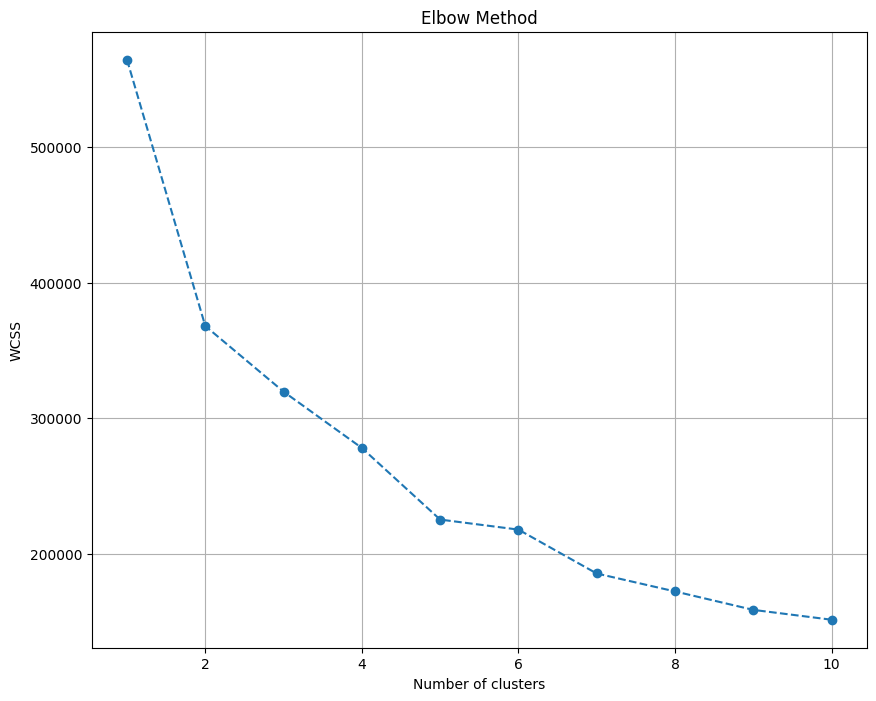

In [83]:
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i)
    kmeans.fit(df_student_perf)
    wcss.append(kmeans.inertia_)

plt.figure(figsize=(10, 8))
plt.plot(range(1, 11), wcss, marker = "o", linestyle = "--")
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.grid()
plt.show()

In [65]:
n_clusters = 5
kmeans = KMeans(n_clusters=n_clusters, verbose=2, random_state=42)
clusters = kmeans.fit_predict(df_student_perf)

df_centroids = kmeans.cluster_centers_
df_distances = cdist(df_student_perf, df_centroids, 'euclidean')

Initialization complete
Iteration 0, inertia 332707.83534640714.
Iteration 1, inertia 252372.6761982423.
Iteration 2, inertia 246775.02590392766.
Iteration 3, inertia 244063.62105124845.
Iteration 4, inertia 240082.83644594072.
Iteration 5, inertia 232072.19644672013.
Iteration 6, inertia 227359.5126203842.
Iteration 7, inertia 225817.64199646763.
Iteration 8, inertia 225369.68733693572.
Iteration 9, inertia 225120.6816277745.
Iteration 10, inertia 224994.8804828039.
Iteration 11, inertia 224957.8835374078.
Iteration 12, inertia 224948.27630984256.
Converged at iteration 12: strict convergence.


In [66]:
cluster_list = []

for c in clusters:
    cluster_list.append(c)
           
df_student_perf["Cluster"] = cluster_list

In [67]:
df_student_perf

,Previous_qualification_(grade),Admission_grade,Curricular_units_1st_sem_(credited),Curricular_units_1st_sem_(enrolled),Curricular_units_1st_sem_(evaluations),Curricular_units_1st_sem_(approved),Curricular_units_1st_sem_(grade),Curricular_units_1st_sem_(without_evaluations),Curricular_units_2nd_sem_(credited),Curricular_units_2nd_sem_(enrolled),Curricular_units_2nd_sem_(evaluations),Curricular_units_2nd_sem_(approved),Curricular_units_2nd_sem_(grade),Curricular_units_2nd_sem_(without_evaluations),Cluster
Fake_StudentID,,,,,,,,,,,,,,,
14519294A,122.0,124.8,0,6,0,0,0.000000,0,0,6,0,0,0.000000,0,3
17184547C,119.0,113.1,0,5,5,0,0.000000,0,0,5,5,0,0.000000,0,2
42143220A,138.0,123.0,0,6,9,5,11.400000,0,0,6,14,2,13.500000,0,1
21378093B,133.0,130.2,0,6,6,0,0.000000,0,0,6,0,0,0.000000,0,3
39750802A,127.0,120.7,0,6,6,5,13.200000,0,0,6,7,0,0.000000,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53385051A,150.0,140.0,3,5,10,3,14.666667,1,0,5,5,0,0.000000,0,4
14593822D,133.1,120.0,0,6,12,1,11.000000,0,0,6,9,2,10.500000,0,1
86947830A,100.0,133.0,0,6,8,5,11.400000,0,0,6,10,6,11.666667,0,2


In [68]:
silhouette_avg = silhouette_score(df_student_perf, clusters)
print(f"Índice de Silueta promedio: {silhouette_avg}")

davies_bouldin = davies_bouldin_score(df_student_perf, clusters)
print(f"Índice de Davies-Bouldin: {davies_bouldin}")

calinski_harabasz = calinski_harabasz_score(df_student_perf, clusters)
print(f"Índice de Calinski-Harabasz: {calinski_harabasz}")

Índice de Silueta promedio: 0.26202590337653814
Índice de Davies-Bouldin: 1.192818728026111
Índice de Calinski-Harabasz: 437.1076261846336


In [69]:
df_cluster_students = df_dropout.copy()
df_cluster_students["Cluster"] = clusters

In [70]:
#Describe the clusters
cluster_analysis = df_cluster_students.groupby('Cluster').describe().T
pd.set_option('display.max_rows', None)

In [71]:
cluster_analysis.loc[df_student_perf_features]

Cluster                                                        0           1  \
Previous_qualification_(grade)                 count  152.000000  326.000000   
                                               mean   135.006579  131.469325   
                                               std      7.401679    6.871971   
                                               min    120.000000  110.000000   
                                               25%    133.100000  127.000000   
                                               50%    133.100000  132.000000   
                                               75%    133.100000  135.000000   
                                               max    170.000000  158.000000   
Admission_grade                                count  152.000000  326.000000   
                                               mean   104.094737  127.228834   
                                               std      5.584093    6.859775   
                                               min     95.000000  114.000000   
                                               25%    100.000000  122.100000   
                                               50%    102.500000  127.250000   
                                               75%    110.000000  131.000000   
                                               max    118.000000  160.000000   
Curricular_units_1st_sem_(credited)            count  152.000000  326.000000   
                                               mean     0.276316    0.315951   
                                               std      0.936369    1.067646   
                                               min      0.000000    0.000000   
                                               25%      0.000000    0.000000   
                                               50%      0.000000    0.000000   
                                               75%      0.000000    0.000000   
                                               max      6.000000    8.000000   
Curricular_units_1st_sem_(enrolled)            count  152.000000  326.000000   
                                               mean     5.815789    6.015337   
                                               std      1.118307    1.018178   
                                               min      2.000000    3.000000   
                                               25%      5.000000    5.000000   
                                               50%      6.000000    6.000000   
                                               75%      6.000000    6.000000   
                                               max     10.000000   12.000000   
Curricular_units_1st_sem_(evaluations)         count  152.000000  326.000000   
                                               mean     8.236842    9.453988   
                                               std      4.521819    2.895519   
                                               min      0.000000    3.000000   
                                               25%      5.000000    7.000000   
                                               50%      8.000000    9.000000   
                                               75%     11.000000   11.000000   
                                               max     19.000000   20.000000   
Curricular_units_1st_sem_(approved)            count  152.000000  326.000000   
                                               mean     1.736842    4.162577   
                                               std      2.054673    1.752698   
                                               min      0.000000    0.000000   
                                               25%      0.000000    3.000000   
                                               50%      1.000000    4.000000   
                                               75%      3.000000    5.750000   
                                               max      8.000000   11.000000   
Curricular_units_1st_sem_(grade)               count  152.000000  326.000000   


In [72]:
pd.set_option('display.max_rows', False)

In [73]:
dict_clusters_students = {cluster: group.drop(columns=["Cluster"]) for cluster, group in df_cluster_students.groupby("Cluster")}

In [74]:
dict_clusters_selected_students = get_students(df_cluster_students, df_dropout, df_distances, df_centroids, "farthest", 0.05)

Cluster 0: 8 students
Cluster 1: 17 students
Cluster 2: 13 students
Cluster 3: 13 students
Cluster 4: 10 students


In [75]:
dict_cluster_centroids_students = get_centroids(df_cluster_students, df_dropout, df_distances, df_centroids)

In [77]:
df_cluster_gcfe = pd.DataFrame(columns=X_train.columns.tolist())

for cluster in dict_clusters_students.keys():
    print(f"Cluster {cluster}")
    start_time = time.time()
    centroid_student, cluster_students, features, _, _, _, gcfe_values_coverage, gcfe = GCFE_features_clustering(dict_clusters_selected_students[cluster], positive_train_set, model, exp, features_to_vary, sample_size_percentage=0.3, n_features_percentage=0.2, global_features_importance=False)
    end_time = time.time()
    exec_time = end_time - start_time
    df_cluster_gcfe = pd.concat([df_cluster_gcfe, gcfe], ignore_index=True)

Cluster 0


100%|██████████| 1/1 [00:00<00:00,  1.80it/s]


Cluster 1


100%|██████████| 1/1 [00:00<00:00,  1.83it/s]


Cluster 2


100%|██████████| 1/1 [00:00<00:00,  1.31it/s]


Cluster 3


100%|██████████| 1/1 [00:00<00:00,  1.68it/s]


Cluster 4


100%|██████████| 1/1 [00:00<00:00,  1.85it/s]


In [73]:
df_cluster_gcfe

,Marital_status,Application_mode,Application_order,Course,Daytime/evening_attendance,Previous_qualification,Previous_qualification_(grade),Nacionality,Mother's_qualification,Father's_qualification,Mother's_occupation,Father's_occupation,Admission_grade,Displaced,Educational_special_needs,Debtor,Tuition_fees_up_to_date,Gender,Scholarship_holder,Age_at_enrollment,International,Curricular_units_1st_sem_(credited),Curricular_units_1st_sem_(enrolled),Curricular_units_1st_sem_(evaluations),Curricular_units_1st_sem_(approved),Curricular_units_1st_sem_(grade),Curricular_units_1st_sem_(without_evaluations),Curricular_units_2nd_sem_(credited),Curricular_units_2nd_sem_(enrolled),Curricular_units_2nd_sem_(evaluations),Curricular_units_2nd_sem_(approved),Curricular_units_2nd_sem_(grade),Unemployment_rate,Inflation_rate,GDP
0,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,1.0,-,-,-,-,-,-,-,6.0,12.285714,-,-,-,10.0,6.0,13.700000,-,-,-
1,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,1.0,-,-,-,-,-,-,-,8.0,12.200000,-,-,-,12.0,6.0,12.416667,-,-,-
2,-,-,-,-,-,-,-,-,-,-,-,-,119.0,-,-,-,1.0,-,-,-,-,-,-,-,5.0,13.400000,-,-,-,-,7.0,12.428571,-,-,-
3,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,1.0,-,-,-,-,-,-,-,6.0,12.285714,-,-,-,10.0,6.0,13.700000,-,-,-
4,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,1.0,-,-,-,-,-,-,7.0,9.0,11.666667,-,-,-,-,8.0,14.125000,-,-,-


In [103]:
success_percentage(dict_clusters_selected_students, positive_train_set, dict_clusters_students, X_train, model, exp, features_to_vary, n_clusters, sample_size_percentage=1, n_features_percentage=0.5, n_loops=5, global_features_importance=False)

Cluster 0


100%|██████████| 1/1 [00:01<00:00,  1.15s/it]


Cluster 1


100%|██████████| 1/1 [00:00<00:00,  1.26it/s]


Cluster 2


100%|██████████| 1/1 [00:01<00:00,  1.15s/it]


Cluster 3


100%|██████████| 1/1 [00:00<00:00,  1.12it/s]


Cluster 4


100%|██████████| 1/1 [00:01<00:00,  1.15s/it]


Run 1, Cluster 0 accuracy: 100.00%
Run 1, Cluster 1 accuracy: 100.00%
Run 1, Cluster 2 accuracy: 100.00%
Run 1, Cluster 3 accuracy: 100.00%
Run 1, Cluster 4 accuracy: 99.64%
Run 1 mean accuracy: 99.93%
Cluster 0


100%|██████████| 1/1 [00:01<00:00,  1.15s/it]


Cluster 1


100%|██████████| 1/1 [00:00<00:00,  1.25it/s]


Cluster 2


100%|██████████| 1/1 [00:01<00:00,  1.24s/it]


Cluster 3


100%|██████████| 1/1 [00:01<00:00,  1.18s/it]


Cluster 4


100%|██████████| 1/1 [00:00<00:00,  1.15it/s]


Run 2, Cluster 0 accuracy: 99.10%
Run 2, Cluster 1 accuracy: 100.00%
Run 2, Cluster 2 accuracy: 100.00%
Run 2, Cluster 3 accuracy: 98.37%
Run 2, Cluster 4 accuracy: 98.19%
Run 2 mean accuracy: 99.13%
Cluster 0


100%|██████████| 1/1 [00:01<00:00,  1.01s/it]


Cluster 1


100%|██████████| 1/1 [00:00<00:00,  1.28it/s]


Cluster 2


100%|██████████| 1/1 [00:01<00:00,  1.58s/it]


Cluster 3


100%|██████████| 1/1 [00:00<00:00,  1.11it/s]


Cluster 4


100%|██████████| 1/1 [00:01<00:00,  1.42s/it]


Run 3, Cluster 0 accuracy: 100.00%
Run 3, Cluster 1 accuracy: 100.00%
Run 3, Cluster 2 accuracy: 100.00%
Run 3, Cluster 3 accuracy: 100.00%
Run 3, Cluster 4 accuracy: 100.00%
Run 3 mean accuracy: 100.00%
Cluster 0


100%|██████████| 1/1 [00:01<00:00,  1.02s/it]


Cluster 1


100%|██████████| 1/1 [00:00<00:00,  1.34it/s]


Cluster 2


100%|██████████| 1/1 [00:01<00:00,  1.32s/it]


Cluster 3


100%|██████████| 1/1 [00:00<00:00,  1.15it/s]


Cluster 4


100%|██████████| 1/1 [00:01<00:00,  1.18s/it]


Run 4, Cluster 0 accuracy: 100.00%
Run 4, Cluster 1 accuracy: 100.00%
Run 4, Cluster 2 accuracy: 100.00%
Run 4, Cluster 3 accuracy: 98.37%
Run 4, Cluster 4 accuracy: 99.64%
Run 4 mean accuracy: 99.60%
Cluster 0


100%|██████████| 1/1 [00:01<00:00,  1.11s/it]


Cluster 1


100%|██████████| 1/1 [00:00<00:00,  1.53it/s]


Cluster 2


100%|██████████| 1/1 [00:01<00:00,  1.15s/it]


Cluster 3


100%|██████████| 1/1 [00:00<00:00,  1.35it/s]


Cluster 4


100%|██████████| 1/1 [00:01<00:00,  1.36s/it]


Run 5, Cluster 0 accuracy: 100.00%
Run 5, Cluster 1 accuracy: 100.00%
Run 5, Cluster 2 accuracy: 100.00%
Run 5, Cluster 3 accuracy: 99.19%
Run 5, Cluster 4 accuracy: 100.00%
Run 5 mean accuracy: 99.84%
Overall mean accuracy after 5 runs: 99.70%


(99.70027930545673,
 [61.874778509140015,
  62.9096896648407,
  62.505258321762085,
  59.324002265930176,
  51.61811876296997])

## Evaluation

### Preparing data

In [179]:
dict_clusters_students = get_students(df_with_cluster, df_dropout, df_distances, df_centroids, "closest", 1)

Cluster 0: 152 students
Cluster 1: 326 students
Cluster 2: 242 students
Cluster 3: 253 students
Cluster 4: 191 students


In [ ]:
dict_clusters_cfe = {}
dict_clusters_creation_times = {} 

for cluster_id, original_cluster in dict_clusters_students.items():
    modified_rows = []
    creation_times = [] 

    for i in range(original_cluster.shape[0]):
        start_time = time.time()  

        individual_cf = exp.generate_counterfactuals(original_cluster.iloc[[i]], total_CFs=1, desired_class=0, features_to_vary=features_to_vary, verbose=0)
        instance = original_cluster.iloc[i]
        cfe = individual_cf.cf_examples_list[0].final_cfs_df.squeeze()
        cfe = cfe.drop(labels="Target")

        modified_row = {}
        
        for column in cfe.index:
            if cfe[column] != instance[column]:
                modified_row[column] = cfe[column] 
            else:
                modified_row[column] = '-'  
        
        modified_rows.append(modified_row)

        end_time = time.time() 
        creation_time = end_time - start_time 
        creation_times.append(creation_time)  

    individual_cfs_only_changes = pd.DataFrame(modified_rows)
    dict_clusters_cfe[cluster_id] = individual_cfs_only_changes
    dict_clusters_creation_times[cluster_id] = creation_times

### Evaluation functions

In [180]:
# Get the best combination for group counterfactual generation

def evaluate_group_cfe_generation_techniques(df_cluster_students, df_dropout, dict_clusters_students, distances, centroids, positive_train_set, X_train, model, explainer, features_to_vary, n_clusters, sample_size_percentage=0.5, n_features_percentage=0.3, n_loops=5, global_features_importance=False):
    # Define the different techniques and sample percentages to evaluate
    techniques = ['closest', 'farthest', 'random', 'centroids', 'full']
    percentages = [0.01, 0.05, 0.1, 0.25, 0.5]  # 1%, 5%, 10%, 25%, 50%
    
    # Initialize lists to store results and index values
    results = []
    index_list = []
    
    # Loop through each generation technique
    for technique in techniques:
        
        # Handle the 'centroids' technique where only centroids are selected
        if technique == 'centroids':
            print(f"Technique: {technique}")
            percentage = 'Only centroids'
            # Get the students corresponding to centroids
            dict_cluster_centroids_students = get_centroids(df_cluster_students, df_dropout, distances, centroids)
            start_time = time.time()
            # Calculate the success rate and execution time for centroids
            success_rate, total_time = success_percentage(
                dict_cluster_centroids_students, positive_train_set, dict_clusters_students, X_train, model, explainer,
                features_to_vary, n_clusters, sample_size_percentage, n_features_percentage, n_loops, global_features_importance
            )
            end_time = time.time()
            exec_time = (end_time - start_time) / n_loops  # Average execution time per loop
            total_exec_time = end_time - start_time  # Total execution time
            index_list.append((technique, ""))  # Append to index
            results.append([success_rate, exec_time, total_exec_time])  # Append to results
        
        # Handle the 'full' technique where all students are used
        elif technique == 'full':
            print(f"Technique: {technique}, Percentage: 100%")
            percentage = 1.0  # 100%
            # Get all students for the 'full' technique
            df_all_students = get_students(df_cluster_students, df_dropout, distances, centroids, "closest", percentage)
            start_time = time.time()
            # Calculate the success rate and execution time for all students
            success_rate, total_time = success_percentage(
                df_all_students, positive_train_set, dict_clusters_students, X_train, model, explainer, features_to_vary,
                n_clusters, sample_size_percentage, n_features_percentage, n_loops, global_features_importance
            )
            end_time = time.time()
            exec_time = (end_time - start_time) / n_loops
            total_exec_time = end_time - start_time
            index_list.append((technique, f"{percentage * 100}%"))
            results.append([success_rate, exec_time, total_exec_time])
        
        # Handle the remaining techniques with variable sampling percentages
        else:
            for percentage in percentages:
                print(f"Technique: {technique}, Percentage: {percentage}")
                # Select students based on the technique and percentage
                df_selected_students = get_students(df_cluster_students, df_dropout, distances, centroids, technique, percentage)
                start_time = time.time()
                # Calculate the success rate and execution time for selected students
                success_rate, total_time = success_percentage(
                    df_selected_students, positive_train_set, dict_clusters_students, X_train, model, explainer,
                    features_to_vary, n_clusters, sample_size_percentage, n_features_percentage, n_loops, global_features_importance
                )
                end_time = time.time()
                exec_time = (end_time - start_time) / n_loops
                total_exec_time = end_time - start_time
                index_list.append((technique, f"{percentage * 100}%"))  # Append technique and percentage to index
                results.append([success_rate, exec_time, total_exec_time])  # Append results for each technique and percentage
    
    # Create a DataFrame to store the results with multi-level index (Technique, Percentage students used)
    df_results = pd.DataFrame(results, columns=["Success rate", "Average time", "Total time"],
                      index=pd.MultiIndex.from_tuples(index_list, names=["Technique", "Percentage students used"]))
    
    # Return the results DataFrame
    return df_results


In [181]:
# Get the metrics for each cluster 

def evaluate_single_cluster(df_cluster_students, df_cluster_selected_students, features_to_vary, X_train, model, exp, positive_train_set, categorical_columns, numeric_columns, n_loops=5):
    accumulated_individual = []
    accumulated_group = []
    n_students = len(df_cluster_students)

    # Iterate through multiple loops to gather performance metrics
    for i in range(n_loops):
        print(f"\n--- Evaluating Iteration {i} ---")
        time_individuals = []
        modified_rows = []
        
        # Generate individual counterfactuals for each student in the cluster
        for j in range(df_cluster_students.shape[0]):
            start_time_individual = time.time()

            # Generate individual counterfactual using the explainer
            individual_cf = exp.generate_counterfactuals(df_cluster_students.iloc[[j]], total_CFs=1, desired_class=0, features_to_vary=features_to_vary, verbose=0)
            instance = df_cluster_students.iloc[j]
            
            # Extract and compare counterfactual to the original instance
            cfe = individual_cf.cf_examples_list[0].final_cfs_df.squeeze()
            cfe = cfe.drop(labels="Target")
            
            modified_row = {}

            # Record changes made in the counterfactual compared to the original instance
            for column in cfe.index:
                if cfe[column] != instance[column]:
                    modified_row[column] = cfe[column]
                else:
                    modified_row[column] = '-'  # No change
            
            modified_rows.append(modified_row)

            # Measure time taken for individual counterfactual generation
            end_time_individual = time.time()
            time_individual = end_time_individual - start_time_individual
            time_individuals.append(time_individual)

        # Convert list of modified rows to DataFrame
        individual_cfs_only_changes = pd.DataFrame(modified_rows)

        # Generate group counterfactuals using clustering-based technique
        start_time_group = time.time()
        _, _, _, _, _, _, _, gcfe = GCFE_features_clustering(
            df_cluster_selected_students, positive_train_set, model, exp, features_to_vary, sample_size_percentage=0.3, n_features_percentage=0.2, global_features_importance=False
        )
        group_cf = gcfe.squeeze()
        end_time_group = time.time()
        
        # Calculate average group counterfactual generation time
        group_time = (end_time_group - start_time_group) / n_students
        group_time = [group_time] * n_students  # Duplicate for each student

        # Calculate validity for individual and group counterfactuals
        individual_validities_ = individual_validity(df_cluster_students, individual_cfs_only_changes, model)
        group_validity_ = group_validity(df_cluster_students, group_cf, model)

        # Calculate sparsity for individual and group counterfactuals
        individual_sparsities_ = individual_sparsity(individual_cfs_only_changes)
        group_sparsity_ = group_sparsity(df_cluster_students, group_cf)

        # Calculate proximity (numeric and categorical) for individual and group counterfactuals
        individual_numeric_proximities_, individual_categorical_proximities_ = individual_proximity(
            df_cluster_students, individual_cfs_only_changes, df_numeric_features, df_categorical_features
        )
        group_numeric_proximity_, group_categorical_proximity_ = group_proximity(
            df_cluster_students, group_cf, df_numeric_features, df_categorical_features
        )

        # Accumulate results for each iteration
        accumulated_individual.append([individual_validities_, individual_sparsities_, individual_numeric_proximities_, individual_categorical_proximities_, time_individuals])
        accumulated_group.append([group_validity_, group_sparsity_, group_numeric_proximity_, group_categorical_proximity_, group_time])

    # Compute mean results across iterations for individual and group
    individual_means = []
    group_means = []

    # Loop through each metric (Validity, Sparsity, etc.)
    for column in range(5):
        # Calculate mean for each student across loops
        individual_column_means = [np.nanmean([accumulated_individual[loop][column][i] for loop in range(len(accumulated_individual))]) for i in range(n_students)]
        group_column_means = [np.nanmean([accumulated_group[loop][column][i] for loop in range(len(accumulated_group))]) for i in range(n_students)]

        individual_means.append(individual_column_means)
        group_means.append(group_column_means)

    # Create DataFrames for individual and group results
    individual_df = pd.DataFrame({
        "Validity": individual_means[0],
        "Sparsity": individual_means[1],
        "Numeric proximity": individual_means[2],
        "Categorical proximity": individual_means[3],
        "Time": individual_means[4]
    })

    group_df = pd.DataFrame({
        "Validity": group_means[0],
        "Sparsity": group_means[1],
        "Numeric proximity": group_means[2],
        "Categorical proximity": group_means[3],
        "Time": group_means[4]
    })

    # Add 'Type' column to indicate whether results are for individual or group
    individual_df['Type'] = 'Individual'
    group_df['Type'] = 'Group'

    # Ensure correct column ordering
    individual_df = individual_df[['Type', 'Validity', 'Sparsity', 'Numeric proximity', 'Categorical proximity', 'Time']]
    group_df = group_df[['Type', 'Validity', 'Sparsity', 'Numeric proximity', 'Categorical proximity', 'Time']]

    # Combine individual and group results in alternating rows
    df_results = pd.DataFrame()
    for i in range(len(individual_df)):
        df_results = pd.concat([df_results, individual_df.iloc[[i]], group_df.iloc[[i]]], ignore_index=True)

    # Set index to alternate between students
    df_results.index = [i // 2 for i in range(len(df_results))]

    return df_results


In [182]:
# Evaluate the clusters focused on the individual instances

def evaluate_all_clusters_individual_focused(dict_clusters_students, dict_clusters_selected_students, features_to_vary, X_train, model, exp, positive_train_set, categorical_columns, numeric_columns, n_loops=5):
    all_results = []  # List to store the results of all clusters
    index_list = []  # List to store the MultiIndex tuples for the result DataFrame
    n_students = [len(dict_clusters_students[cluster]) for cluster in dict_clusters_students.keys()]  # Number of students in each cluster

    df_cluster_gcfe = pd.DataFrame(columns=X_train.columns.tolist())  # DataFrame to store group counterfactuals for each cluster

    for cluster_id, cluster_students in dict_clusters_students.items():  # Iterate over each cluster
        cluster_results = []  # Store results for the current cluster over all iterations
        time_individuals = []  # Store times for individual counterfactual generation
        
        for i in range(n_loops):  # Repeat evaluation multiple times for robustness
            print(f"\n--- Evaluating Cluster {cluster_id} iteration {i}---")
            results = []  # Store individual and group results for this iteration
            modified_rows = []  # Store only the modified features for each individual counterfactual
        
            for j in range(cluster_students.shape[0]):  # Process each student in the cluster
                start_time_individual = time.time()  # Track time to generate individual counterfactual

                # Generate individual counterfactual
                individual_cf = exp.generate_counterfactuals(cluster_students.iloc[[j]], total_CFs=1, desired_class=0, features_to_vary=features_to_vary, verbose=0)
                instance = cluster_students.iloc[j]
                
                cfe = individual_cf.cf_examples_list[0].final_cfs_df.squeeze()  # Extract the generated counterfactual
                cfe = cfe.drop(labels="Target")  # Drop the 'Target' column
                
                modified_row = {}  # Track which features were changed
                
                # For each feature, check if the value has changed in the counterfactual
                for column in cfe.index:
                    if cfe[column] != instance[column]:
                        modified_row[column] = cfe[column]  # Store the new value if changed
                    else:
                        modified_row[column] = '-'  # Use '-' to indicate no change
                
                modified_rows.append(modified_row)  # Add the modified row for this individual

                end_time_individual = time.time()  # Track the end time
                time_individual = end_time_individual - start_time_individual  # Calculate the time taken
                time_individuals.append(time_individual)  # Store the time taken for this individual

            # Create DataFrame with only the changed features from individual counterfactuals
            individual_cfs_only_changes = pd.DataFrame(modified_rows)
            mean_time_individual = np.mean(time_individuals)  # Calculate average time for individual counterfactuals
            
            # Generate group counterfactual and measure time
            start_time_group = time.time()
            _, _, _, _, _, _, _, gcfe = GCFE_features_clustering(
                dict_clusters_selected_students[cluster_id], positive_train_set, model, exp, features_to_vary, sample_size_percentage=0.3, n_features_percentage=0.2, global_features_importance=False
            )
            df_cluster_gcfe = pd.concat([df_cluster_gcfe, gcfe], ignore_index=True)  # Store the generated group counterfactual
            end_time_group = time.time()
            group_time = end_time_group - start_time_group  # Calculate total group time

            group_time_individual = group_time / cluster_students.shape[0]  # Average group time per student
            group_cf = gcfe.squeeze()  # Extract group counterfactual

            # Calculate validity for individual and group counterfactuals
            avg_individual_validity, avg_group_validity = compare_validity(cluster_students, group_cf, individual_cfs_only_changes, model)

            # Calculate sparsity for individual and group counterfactuals
            total_individual_sparsity, total_group_sparsity = compare_sparsity(cluster_students, individual_cfs_only_changes, group_cf)

            # Calculate proximity (numeric and categorical) for individual and group counterfactuals
            (avg_individual_proximity_numeric, avg_individual_proximity_categorical), (avg_group_proximity_numeric, avg_group_proximity_categorical) = compare_proximity(
                cluster_students, individual_cfs_only_changes, group_cf, numeric_columns, categorical_columns)

            # Append individual and group results for this iteration
            results.append([avg_individual_validity, total_individual_sparsity, avg_individual_proximity_numeric, avg_individual_proximity_categorical, mean_time_individual])
            results.append([avg_group_validity, total_group_sparsity, avg_group_proximity_numeric, avg_group_proximity_categorical, group_time_individual])
            cluster_results.append(results)

        # Average results over all iterations for this cluster
        averaged_results = np.nanmean(cluster_results, axis=0)

        # Append individual and group results to the final results list
        index_list.append((f"{cluster_id}", f"{n_students[cluster_id]}", "Individual"))
        all_results.append(averaged_results[0])
        
        index_list.append((f"{cluster_id}", f"{n_students[cluster_id]}", "Group"))
        all_results.append(averaged_results[1])
    
    # Create DataFrame to hold all results with MultiIndex for cluster, number of students, and type
    df_results = pd.DataFrame(
        all_results, 
        columns=["Validity", "Sparsity", "Proximity Numeric", "Proximity Categorical", "Time per counterfactual"],
        index=pd.MultiIndex.from_tuples(index_list, names=["Cluster", "Cluster Students", "Counterfactual Type"])
    )

    return df_results


In [183]:
# Evaluate the clusters focused on the clusters themselves

def evaluate_all_clusters_group_focused(dict_clusters_students, dict_clusters_selected_students, features_to_vary, X_train, model, exp, positive_train_set, categorical_columns, numeric_columns, n_loops=5):
    all_results = []  # List to store the results of all clusters
    index_list = []  # List to store MultiIndex tuples for the result DataFrame
    n_students = [len(dict_clusters_students[cluster]) for cluster in dict_clusters_students.keys()]  # Number of students in each cluster

    df_cluster_gcfe = pd.DataFrame(columns=X_train.columns.tolist())  # DataFrame to store group counterfactuals for each cluster

    for cluster_id, cluster_students in dict_clusters_students.items():  # Iterate over each cluster
        cluster_results = []  # Store results for the current cluster over all iterations
        
        for i in range(n_loops):  # Repeat evaluation multiple times for robustness
            print(f"\n--- Evaluating Cluster {cluster_id} iteration {i}---")
            results = []  # Store individual and group results for this iteration

            # Start timing for individual counterfactual generation
            start_time_individual = time.time()
            individual_cfs = exp.generate_counterfactuals(cluster_students, total_CFs=1, desired_class=0, features_to_vary=features_to_vary, verbose=0)

            modified_rows = []  # Store modified features for each counterfactual
            
            for j in range(cluster_students.shape[0]):  # Process each student in the cluster
                instance = cluster_students.iloc[j]
                cfe = individual_cfs.cf_examples_list[j].final_cfs_df.squeeze()  # Extract the generated counterfactual
                cfe = cfe.drop(labels="Target")  # Drop the 'Target' column
                
                modified_row = {}  # Track which features were changed

                # Check each feature for changes compared to the original instance
                for column in cfe.index:
                    if cfe[column] != instance[column]:
                        modified_row[column] = cfe[column]  # Store new value if changed
                    else:
                        modified_row[column] = '-'  # Use '-' to indicate no change
                        
                modified_rows.append(modified_row)  # Add the modified row for this individual
            
            individual_cfs_only_changes = pd.DataFrame(modified_rows)  # Create DataFrame for modified features
            end_time_individual = time.time()  # End timing for individual counterfactual generation
            individual_time = end_time_individual - start_time_individual  # Calculate time taken
            
            # Start timing for group counterfactual generation
            start_time_group = time.time()
            _, _, _, _, _, _, _, gcfe = GCFE_features_clustering(
                dict_clusters_selected_students[cluster_id], positive_train_set, model, exp, features_to_vary, sample_size_percentage=0.3, n_features_percentage=0.2, global_features_importance=False
            )
            df_cluster_gcfe = pd.concat([df_cluster_gcfe, gcfe], ignore_index=True)  # Store group counterfactual
            end_time_group = time.time()  # End timing for group counterfactual generation
            group_time = end_time_group - start_time_group  # Calculate total group time

            group_cf = gcfe.squeeze()  # Extract the group counterfactual

            # Calculate validity for individual and group counterfactuals
            avg_individual_validity, avg_group_validity = compare_validity(cluster_students, group_cf, individual_cfs_only_changes, model)

            # Calculate sparsity for individual and group counterfactuals
            total_individual_sparsity, total_group_sparsity = compare_sparsity(cluster_students, individual_cfs_only_changes, group_cf)

            # Calculate proximity (numeric and categorical) for individual and group counterfactuals
            (avg_individual_proximity_numeric, avg_individual_proximity_categorical), (avg_group_proximity_numeric, avg_group_proximity_categorical) = compare_proximity(
                cluster_students, individual_cfs_only_changes, group_cf, numeric_columns, categorical_columns)

            # Append individual and group results for this iteration
            results.append([avg_individual_validity, total_individual_sparsity, avg_individual_proximity_numeric, avg_individual_proximity_categorical, individual_time])
            results.append([avg_group_validity, total_group_sparsity, avg_group_proximity_numeric, avg_group_proximity_categorical, group_time])
            cluster_results.append(results)

        # Average results over all iterations for this cluster
        averaged_results = np.nanmean(cluster_results, axis=0)

        # Append individual and group results to the final results list
        index_list.append((f"{cluster_id}", f"{n_students[cluster_id]}", "Individual"))
        all_results.append(averaged_results[0])
        
        index_list.append((f"{cluster_id}", f"{n_students[cluster_id]}", "Group"))
        all_results.append(averaged_results[1])
    
        # Create DataFrame to hold all results with MultiIndex for cluster, number of students, and type
    df_results = pd.DataFrame(
        all_results, 
        columns=["Validity", "Sparsity", "Proximity Numeric", "Proximity Categorical", "Time per cluster"],
        index=pd.MultiIndex.from_tuples(index_list, names=["Cluster", "Cluster Students", "Counterfactual Type"])
    )

    return df_results

### Best group counterfactual generation technique

In [ ]:
results = evaluate_group_cfe_generation_techniques(df_cluster_students, df_dropout, dict_clusters_students, df_distances, df_centroids, positive_train_set, X_train, model, exp, features_to_vary, n_clusters, sample_size_percentage=0.5, n_features_percentage=0.3, n_loops=5, global_features_importance=False)

In [ ]:
results

Success rate  Average time   Total time
Technique Percentage                                         
closest   1.0%           85.879205     12.614833    63.074165
          5.0%           97.982937     56.085981   280.429905
          10.0%          99.607172    110.118154   550.590770
          25.0%          99.653343    262.564846  1312.824231
          50.0%          99.944975    517.338012  2586.690061
farthest  1.0%           84.647641     14.869617    74.348087
          5.0%           99.647773     59.835556   299.177782
          10.0%          99.595727    114.496031   572.480156
          25.0%          99.899344    281.777009  1408.885045
          50.0%          99.911967    552.645595  2763.227973
random    1.0%           73.056074    259.579020  1297.895098
          5.0%           94.764340     89.398266   446.991328
          10.0%          99.609164    103.373178   516.865889
          25.0%          99.756522    259.219084  1296.095419
          50.0%          99.959967    489.396498  2446.982492
centroids                74.093656      5.172265    25.861324
full      100.0%        100.000000    942.836390  4714.181952

### Individual focused comparation metrics

In [185]:
# Applies a counterfactual to a student by modifying only the columns where the counterfactual suggests a change.

def apply_counterfactual(row, counterfactual):
    for col in row.index:
        if counterfactual[col] != '-':
            row[col] = counterfactual[col]
    
    return row


# Evaluates the validity of individual counterfactuals for each student in the cluster.

def individual_validity(df_cluster_students, individual_cfs, model):
    individual_validities = []

    # Iterate over individual counterfactuals and corresponding students
    for i, (index, cf) in enumerate(individual_cfs.iterrows()):
        student = df_cluster_students.iloc[i]
        modified_student = apply_counterfactual(student.copy(), cf) 
        modified_student = modified_student.to_frame().T
        
        # Predict whether the modified student is classified as valid (class 0)
        individual_validity = model.predict(modified_student)
        individual_validity = 1 if individual_validity[0] == 0 else 0
        individual_validities.append(individual_validity)

    return individual_validities


# Evaluates the validity of a group counterfactual applied to all students in the cluster.

def group_validity(df_cluster_students, group_cf, model):
    # Applies the group counterfactual to each student in the cluster
    modified_cluster = df_cluster_students.apply(lambda row: apply_counterfactual(row, group_cf), axis=1)
    
    # Predict whether each modified student is classified as valid (class 0)
    group_validities = model.predict(modified_cluster)
    group_validities = np.array([1 if validity == 0 else 0 for validity in group_validities])
    
    return group_validities


# Compares the validity of individual and group counterfactuals for the given cluster of students.

def compare_validity(df_cluster_students, individual_cfs, group_cf, model):
    # Get validity scores for both group and individual counterfactuals
    group_validities = group_validity(df_cluster_students, group_cf, model)
    individual_validities = individual_validity(df_cluster_students, individual_cfs, model)
    
    # Calculate the average validity for both cases
    avg_individual_validity = sum(individual_validities) / len(individual_validities)
    avg_group_validity = sum(group_validities) / len(group_validities)

    print(f"Mean validity individual counterfactuals: {avg_individual_validity}")
    print(f"Mean validity group counterfactuals: {avg_group_validity}\n")

    return avg_individual_validity, avg_group_validity


In [186]:
compare_validity(dict_clusters_students[0], dict_clusters_cfe[0], df_cluster_gcfe.iloc[0], model)

Mean validity individual counterfactuals: 0.4144736842105263
Mean validity group counterfactuals: 0.993421052631579



(0.4144736842105263, 0.993421052631579)

In [187]:
# Calculates the sparsity of individual counterfactuals.

def individual_sparsity(individual_cfs):
    individual_sparsities = []

    # Iterates through each counterfactual
    for _, cf in individual_cfs.iterrows():
        # Calculates the ratio of unchanged features (features that are '-')
        individual_sparsity = sum(cf != '-') / cf.size
        individual_sparsity = 1 - individual_sparsity  # Sparsity is higher when fewer features change
        individual_sparsities.append(individual_sparsity)
        
    return individual_sparsities


# Calculates the sparsity of a group counterfactual when applied to individual students.

def group_sparsity(df_cluster_students, group_cf):
    group_sparsities = []

    # Iterates through each student in the cluster
    for _, student in df_cluster_students.iterrows():
        instance_group_sparsity = 0

        # Compares each feature in the student's data with the group counterfactual
        for col in group_cf.index:
            if group_cf[col] != '-':  # Only count features that have been changed in the counterfactual
                if student[col] != group_cf[col]:
                    instance_group_sparsity += 1  # Increments when the student’s feature differs from the counterfactual

        # Calculates the sparsity for the current student
        group_sparsity = instance_group_sparsity / group_cf.size
        group_sparsity = 1 - group_sparsity  # Higher sparsity means fewer changes
        group_sparsities.append(group_sparsity)
    
    return group_sparsities


# Compares the average sparsity of individual and group counterfactuals.

def compare_sparsity(df_cluster_students, individual_cfs, group_cf):
    # Retrieves individual and group sparsity scores
    individual_sparsities = individual_sparsity(individual_cfs)
    group_sparsities = group_sparsity(df_cluster_students, group_cf)

    # Computes the average sparsity for both individual and group counterfactuals
    avg_individual_sparsity = sum(individual_sparsities) / len(individual_sparsities)
    avg_group_sparsity = sum(group_sparsities) / len(group_sparsities)
    
    # Prints out the mean sparsity for comparison
    print(f"Mean sparsity individual counterfactuals: {avg_individual_sparsity}")
    print(f"Mean sparsity group counterfactuals: {avg_group_sparsity}\n")
    
    return avg_individual_sparsity, avg_group_sparsity


In [188]:
compare_sparsity(dict_clusters_students[0], dict_clusters_cfe[0], df_cluster_gcfe.iloc[0])

Mean sparsity individual counterfactuals: 0.9214181286549709
Mean sparsity group counterfactuals: 0.8618421052631579



(0.9214181286549709, 0.8618421052631579)

In [189]:
# Calculates the Median Absolute Deviation (MAD) for specified numeric columns in the DataFrame of students who dropped out.

def calculate_mad(df_dropout, numeric_columns):
    return df_dropout[numeric_columns].apply(lambda x: (x - x.median()).abs().median())


# Calculates numeric proximity between the original student data and the counterfactual.

def calculate_numeric_proximity(original, cf, mad_values):
    n_num_columns = len(original)
    valid = (cf != '-') & (mad_values != 0)
    
    if np.sum(valid) == 0:
        return np.nan  # Return NaN if no valid features exist
    
    sum_continuous_distance = 0
    for i in range(n_num_columns):
        if valid[i]:
            continuous_distance = np.sum(np.abs(cf.iloc[i] - original.iloc[i]) / mad_values[i])
            sum_continuous_distance += continuous_distance
    
    continuous_distance = sum_continuous_distance / n_num_columns  # Average distance calculation

    proximity = -continuous_distance  # Proximity is negative of distance

    return proximity  


# Calculates categorical proximity by comparing original data with the counterfactual.

def calculate_categorical_proximity(original, cf):
    n_cat_columns = len(original)
    valid = cf != '-'

    if np.sum(valid) == 0:
        return 1  # Return proximity of 1 if all features are unchanged

    categorical_distance = 0
    for i in range(n_cat_columns):
        if valid[i]:
            if cf.iloc[i] != original.iloc[i]:
                categorical_distance += 1  # Count how many features differ

    categorical_distance /= n_cat_columns  # Normalize by number of features 

    proximity = 1 - categorical_distance  # Proximity is inverse of distance

    return proximity


# Calculates numeric and categorical proximity for individual counterfactuals against the original data in the cluster.

def individual_proximity(df_cluster_students, individual_cfs, numeric_columns, categorical_columns):
    # Calculate the MAD for numeric columns
    mad_values = calculate_mad(df_cluster_students, numeric_columns)
    
    individual_proximity_numeric = []
    individual_proximity_categorical = []
    
    # Iterate over original students and their corresponding individual counterfactuals
    for (_, orig), (_, ind_cf) in zip(df_cluster_students.iterrows(), individual_cfs.iterrows()):
        orig_numeric = orig[numeric_columns]
        ind_numeric = ind_cf[numeric_columns]
       
        orig_categorical = orig[categorical_columns]
        ind_categorical = ind_cf[categorical_columns]

        # Calculate proximity for numeric and categorical data
        cont_proximity = calculate_numeric_proximity(orig_numeric, ind_numeric, mad_values)
        cat_proximity = calculate_categorical_proximity(orig_categorical, ind_categorical)

        individual_proximity_numeric.append(cont_proximity)
        individual_proximity_categorical.append(cat_proximity)
    
    return (individual_proximity_numeric, individual_proximity_categorical)


# Calculates numeric and categorical proximity for the group counterfactual against each student in the cluster.

def group_proximity(df_cluster_students, group_cf, numeric_columns, categorical_columns):
    mad_values = calculate_mad(df_cluster_students, numeric_columns)
    
    group_proximity_numeric = []
    group_proximity_categorical = []
    
    # Iterate over each original student to calculate proximity to the group counterfactual
    for _, orig in df_cluster_students.iterrows():
        orig_numeric = orig[numeric_columns]
        group_numeric = group_cf[numeric_columns]

        orig_categorical = orig[categorical_columns]
        group_categorical = group_cf[categorical_columns]

        cont_proximity = calculate_numeric_proximity(orig_numeric, group_numeric, mad_values)
        cat_proximity = calculate_categorical_proximity(orig_categorical, group_categorical)
        
        group_proximity_numeric.append(cont_proximity)
        group_proximity_categorical.append(cat_proximity)

    return (group_proximity_numeric, group_proximity_categorical)


# Compares the average numeric and categorical proximity for individual and group counterfactuals.

def compare_proximity(df_cluster_students, individual_cfs, group_cf, numeric_columns, categorical_columns):
    individual_proximity_numeric, individual_proximity_categorical = individual_proximity(df_cluster_students, individual_cfs, numeric_columns, categorical_columns) 
    
    # Calculate the average proximity for individual counterfactuals
    avg_individual_proximity_numeric = np.nanmean(individual_proximity_numeric)
    avg_individual_proximity_categorical = np.nanmean(individual_proximity_categorical)

    print(f"Mean numeric proximity individual counterfactuals: {avg_individual_proximity_numeric}")
    print(f"Mean categoric proximity individual counterfactuals: {avg_individual_proximity_categorical}\n")
    
    # Calculate the proximity for the group counterfactuals
    group_proximity_numeric, group_proximity_categorical = group_proximity(df_cluster_students, group_cf, numeric_columns, categorical_columns)
    
    avg_group_proximity_numeric = np.nanmean(group_proximity_numeric)
    avg_group_proximity_categorical = np.nanmean(group_proximity_categorical)

    print(f"Mean numeric proximity group counterfactuals: {avg_group_proximity_numeric}")
    print(f"Mean categoric proximity group counterfactuals: {avg_group_proximity_categorical}")

    return (avg_individual_proximity_numeric, avg_individual_proximity_categorical), (avg_group_proximity_numeric, avg_group_proximity_categorical)


In [190]:
compare_proximity(dict_clusters_students[0], dict_clusters_cfe[0], df_cluster_gcfe.iloc[0], df_numeric_features, df_categorical_features)

Mean numeric proximity individual counterfactuals: -0.35360243903655386
Mean categoric proximity individual counterfactuals: 0.9820906432748537

Mean numeric proximity group counterfactuals: -0.2390350877192982
Mean categoric proximity group counterfactuals: 0.8877923976608187


((-0.35360243903655386, 0.9820906432748537),
 (-0.2390350877192982, 0.8877923976608187))

### Individual focused comparation evaluation, all clusters

In [ ]:
# Evaluar todos los clústeres y obtener los resultados, 30 loops
cluster_results = evaluate_all_clusters_individual_focused(dict_clusters_students, dict_clusters_selected_students, features_to_vary, X_train, model, exp, positive_train_set, df_categorical_features, df_numeric_features, n_loops=30)

In [204]:
cluster_results

Validity  Sparsity  \
Cluster Cluster Students Counterfactual Type                       
0       152              Individual           1.000000  0.920060   
                         Group                0.989474  0.858973   
1       326              Individual           1.000000  0.948864   
                         Group                0.985276  0.868260   
2       242              Individual           1.000000  0.927028   
                         Group                0.986226  0.858257   
3       253              Individual           1.000000  0.904663   
                         Group                0.978393  0.858256   
4       191              Individual           1.000000  0.930895   
                         Group                0.927051  0.867893   

                                              Proximity Numeric  \
Cluster Cluster Students Counterfactual Type                      
0       152              Individual                   -0.379274   
                         Group                        -0.306853   
1       326              Individual                   -0.334695   
                         Group                        -0.556526   
2       242              Individual                   -0.533156   
                         Group                        -0.686963   
3       253              Individual                   -0.233334   
                         Group                        -0.121881   
4       191              Individual                   -0.262089   
                         Group                        -0.223769   

                                              Proximity Categorical  \
Cluster Cluster Students Counterfactual Type                          
0       152              Individual                        0.968104   
                         Group                             0.931116   
1       326              Individual                        0.971438   
                         Group                             0.957203   
2       242              Individual                        0.964539   
                         Group                             0.957407   
3       253              Individual                        0.968072   
                         Group                             0.955512   
4       191              Individual                        0.970525   
                         Group                             0.938055   

                                              Time per counterfactual  
Cluster Cluster Students Counterfactual Type                           
0       152              Individual                          0.702299  
                         Group                               0.038775  
1       326              Individual                          0.583278  
                         Group                               0.053370  
2       242              Individual                          0.670984  
                         Group                               0.049183  
3       253              Individual                          0.764334  
                         Group                               0.056581  
4       191              Individual                          0.655791  
                         Group                               0.038174

### Individual focused comparation evaluation, separate clusters

#### Cluster 0

In [ ]:
cluster_0_df = evaluate_single_cluster(dict_clusters_students[0], dict_clusters_selected_students[0], features_to_vary, X_train, model, exp, positive_train_set, df_categorical_features, df_numeric_features, n_loops=5)

In [310]:
cluster_0_df

,Type,Validity,Sparsity,Numeric proximity,Categorical proximity,Time
0,Individual,1.0,0.833333,-0.201382,0.877778,1.497584
0,Group,1.0,0.833333,-0.402183,0.866667,0.065202
1,Individual,1.0,0.933333,-0.118056,0.977778,0.726771
1,Group,1.0,0.850000,-0.111508,0.866667,0.065202
2,Individual,1.0,0.877778,-0.486270,0.933333,0.976081
2,Group,1.0,0.838889,-0.400198,0.877778,0.065202
3,Individual,1.0,0.944444,-0.416667,1.000000,0.629911
3,Group,1.0,0.861111,-0.252381,0.922222,0.065202
4,Individual,1.0,0.938889,-0.259259,1.000000,0.677138
...,...,...,...,...,...,...


In [311]:
cluster_0_df.to_csv("cluster_0_results.csv")

#### Cluster 1

In [ ]:
cluster_1_df = evaluate_single_cluster(dict_clusters_students[1], dict_clusters_selected_students[1], features_to_vary, X_train, model, exp, positive_train_set, df_categorical_features, df_numeric_features, n_loops=5)

In [313]:
cluster_1_df

,Type,Validity,Sparsity,Numeric proximity,Categorical proximity,Time
0,Individual,1.0,0.966667,-0.203464,1.000000,0.628109
0,Group,1.0,0.866667,-0.279092,0.922222,0.092079
1,Individual,1.0,0.955556,-0.212963,1.000000,0.698415
1,Group,1.0,0.866667,-0.518032,0.922222,0.092079
2,Individual,1.0,0.950000,-0.290580,1.000000,0.646618
2,Group,1.0,0.883333,-0.414367,0.933333,0.092079
3,Individual,1.0,0.950000,-0.247504,1.000000,1.034099
3,Group,1.0,0.872222,-0.564089,0.922222,0.092079
4,Individual,1.0,0.950000,-0.091455,0.944444,0.684767
...,...,...,...,...,...,...


In [314]:
cluster_1_df.to_csv("cluster_1_results.csv")

#### Cluster 2

In [ ]:
cluster_2_df = evaluate_single_cluster(dict_clusters_students[2], dict_clusters_selected_students[2], features_to_vary, X_train, model, exp, positive_train_set, df_categorical_features, df_numeric_features, n_loops=5)

In [316]:
cluster_2_df

,Type,Validity,Sparsity,Numeric proximity,Categorical proximity,Time
0,Individual,1.0,0.944444,-0.133232,0.944444,0.605108
0,Group,1.0,0.838889,-0.448061,0.922222,0.045664
1,Individual,1.0,0.944444,-0.590653,0.977778,0.567542
1,Group,1.0,0.861111,-0.692716,0.977778,0.045664
2,Individual,1.0,0.950000,-0.396296,0.977778,0.568154
2,Group,1.0,0.861111,-0.536992,0.977778,0.045664
3,Individual,1.0,0.938889,-0.302778,0.944444,0.642885
3,Group,1.0,0.833333,-0.651975,0.922222,0.045664
4,Individual,1.0,0.944444,-0.222441,0.933333,0.566748
...,...,...,...,...,...,...


In [317]:
cluster_2_df.to_csv("cluster_2_results.csv")

#### Cluster 3

In [ ]:
cluster_3_df = evaluate_single_cluster(dict_clusters_students[3], dict_clusters_selected_students[3], features_to_vary, X_train, model, exp, positive_train_set, df_categorical_features, df_numeric_features, n_loops=5)

In [319]:
cluster_3_df

,Type,Validity,Sparsity,Numeric proximity,Categorical proximity,Time
0,Individual,1.0,0.938889,NaN,1.000000,0.580275
0,Group,1.0,0.877778,-0.044912,0.988889,0.042104
1,Individual,1.0,0.850000,-0.388792,0.900000,1.029600
1,Group,1.0,0.838889,-0.078246,0.933333,0.042104
2,Individual,1.0,0.944444,NaN,1.000000,0.564526
2,Group,1.0,0.866667,-0.078246,0.988889,0.042104
3,Individual,1.0,0.872222,-0.166667,0.922222,0.952493
3,Group,1.0,0.844444,-0.095043,0.944444,0.042104
4,Individual,1.0,0.911111,-0.179272,0.977778,0.714365
...,...,...,...,...,...,...


In [320]:
cluster_3_df.to_csv("cluster_3_results.csv")

#### Cluster 4

In [ ]:
cluster_4_df = evaluate_single_cluster(dict_clusters_students[4], dict_clusters_selected_students[4], features_to_vary, X_train, model, exp, positive_train_set, df_categorical_features, df_numeric_features, n_loops=5)

In [322]:
cluster_4_df

,Type,Validity,Sparsity,Numeric proximity,Categorical proximity,Time
0,Individual,1.0,0.944444,-0.124266,0.988889,0.642217
0,Group,1.0,0.872222,-0.157189,0.988889,0.032204
1,Individual,1.0,0.955556,-0.012037,0.966667,0.884293
1,Group,1.0,0.894444,-0.208220,0.966667,0.032204
2,Individual,1.0,0.944444,-0.376177,1.000000,0.571683
2,Group,0.8,0.861111,-0.146161,0.966667,0.032204
3,Individual,1.0,0.944444,-0.140097,1.000000,0.551230
3,Group,1.0,0.866667,-0.198702,0.977778,0.032204
4,Individual,1.0,0.944444,-0.194444,1.000000,0.564591
...,...,...,...,...,...,...


In [323]:
cluster_4_df.to_csv("cluster_4_results.csv")

### Group focused comparation metrics

In [199]:
# Applies a counterfactual to a student by modifying only the columns where the counterfactual suggests a change.

def apply_counterfactual(row, counterfactual):
    for col in row.index:
        if counterfactual[col] != '-':
            row[col] = counterfactual[col]
    
    return row


# Evaluates the validity of individual counterfactuals based on model predictions.

def individual_validity(df_cluster_students, individual_cfs, model):
    individual_validities = []  # Initialize a list to store validity scores

    # Iterate through each counterfactual
    for _, cf in individual_cfs.iterrows():
        # Apply the counterfactual to the entire cluster of students
        modified_cluster = df_cluster_students.apply(lambda row: apply_counterfactual(row, cf), axis=1)    

        # Make predictions using the model
        predictions = model.predict(modified_cluster)
        zero_predictions_count = sum(predictions == 0)  # Count how many predictions are zero
        individual_validity = zero_predictions_count / len(predictions)  # Calculate validity ratio
        individual_validities.append(individual_validity)  # Store the validity score
        
    return individual_validities  # Return the list of individual validities


# Evaluates the validity of a group counterfactual based on model predictions.

def group_validity(df_cluster_students, group_cf, model):
    # Apply the group counterfactual to the entire cluster
    modified_cluster = df_cluster_students.apply(lambda row: apply_counterfactual(row, group_cf), axis=1)
    predictions = model.predict(modified_cluster)  # Make predictions using the model
    zero_predictions_count = sum(predictions == 0)  # Count how many predictions are zero
    group_validity = zero_predictions_count / len(predictions)  # Calculate validity ratio
    
    return group_validity  # Return the group validity score


# Compares the validity of individual and group counterfactuals, printing the results.

def compare_validity(df_cluster_students, individual_cfs, group_cf, model):
    avg_group_validity = group_validity(df_cluster_students, group_cf, model)  # Get group validity
    individual_validities = individual_validity(df_cluster_students, individual_cfs, model)  # Get individual validities
    
    avg_individual_validity = sum(individual_validities) / len(individual_validities)  # Calculate average individual validity

    print(f"Mean validity individual counterfactuals: {avg_individual_validity}")
    print(f"Mean validity group counterfactuals: {avg_group_validity}\n")

    return avg_individual_validity, avg_group_validity  # Return average validities for both


In [201]:
compare_validity(dict_clusters_students[0], dict_clusters_cfe[0], df_cluster_gcfe.iloc[0], model)

Mean validity individual counterfactuals: 0.4934210526315789
Mean validity group counterfactuals: 0.993421052631579



(0.4934210526315789, 0.993421052631579)

In [202]:
# Calculates the sparsity of individual counterfactuals as the ratio of modified columns.

def individual_sparsity(individual_cfs):
    # Identify columns that have been modified (not equal to '-')
    modified_columns = (individual_cfs != '-').any(axis=0)
    total_modified_columns = modified_columns.sum()  # Count the number of modified columns
    total_columns = individual_cfs.shape[1]  # Get the total number of columns
    
    # Calculate sparsity as the ratio of unmodified columns
    individual_sparsity = total_modified_columns / total_columns
    individual_sparsity = 1 - individual_sparsity  # Convert to sparsity metric

    return individual_sparsity  # Return the sparsity value for individual counterfactuals


# Calculates the sparsity of a group counterfactual.

def group_sparsity(group_cf):
    group_sparsity = sum(group_cf != '-')  # Count the number of modified attributes in the group counterfactual

    # Calculate sparsity as the ratio of unmodified attributes
    group_sparsity = group_sparsity / group_cf.size
    group_sparsity = 1 - group_sparsity  # Convert to sparsity metric

    return group_sparsity  # Return the sparsity value for the group counterfactual


# Compares the sparsity of individual and group counterfactuals, printing the results.

def compare_sparsity(cluster_students, individual_cfs, group_cf):
    total_individual_sparsity = individual_sparsity(individual_cfs)  # Get total individual sparsity
    total_group_sparsity = group_sparsity(group_cf)  # Get total group sparsity
    
    print(f"Total sparsity individual counterfactuals: {total_individual_sparsity}")
    print(f"Total sparsity group counterfactuals: {total_group_sparsity}\n")
    
    return total_individual_sparsity, total_group_sparsity  # Return total sparsities for both


In [204]:
compare_sparsity(dict_clusters_students[0], dict_clusters_cfe[0], df_cluster_gcfe.iloc[0])

Total sparsity individual counterfactuals: 0.25
Total sparsity group counterfactuals: 0.8333333333333334



(0.25, 0.8333333333333334)

In [205]:
# Calculates the Median Absolute Deviation (MAD) for specified numeric columns in the DataFrame of students who dropped out.

def calculate_mad(df_dropout, numeric_columns):
    return df_dropout[numeric_columns].apply(lambda x: (x - x.median()).abs().median())


# Calculates the numeric proximity between the original and counterfactual instances based on MAD.

def calculate_numeric_proximity(original, cf, mad_values):
    n_num_columns = len(original)  # Total number of numeric columns
    valid = (cf != '-') & (mad_values != 0)  # Identify valid (non-modified and non-zero MAD) entries
    
    # If no valid entries are found, return NaN
    if np.sum(valid) == 0:
        return np.nan
    
    sum_continuous_distance = 0  # Initialize the sum of continuous distances
    for i in range(n_num_columns):
        if valid[i]:  # Process only valid entries
            # Calculate the scaled distance using MAD
            numeric_distance = np.sum(np.abs(cf.iloc[i] - original.iloc[i]) / mad_values[i])
            sum_continuous_distance += numeric_distance  # Accumulate the continuous distance
    
    # Average the distance across all columns
    numeric_distance = sum_continuous_distance / n_num_columns
    numeric_proximity = -numeric_distance  # Return proximity as a negative value

    return numeric_proximity  


# Calculates the categorical proximity between the original and counterfactual instances.

def calculate_categorical_proximity(original, cf):
    n_cat_columns = len(original)  # Total number of categorical columns
    valid = cf != '-'  # Identify valid entries (not modified)

    # If no valid entries are found, return proximity of 1 (maximum proximity)
    if np.sum(valid) == 0:
        return 1

    categorical_distance = 0  # Initialize categorical distance
    for i in range(n_cat_columns):
        if valid[i]:  # Process only valid entries
            # Increment distance if values differ
            if cf.iloc[i] != original.iloc[i]:
                categorical_distance += 1

    categorical_distance /= n_cat_columns  # Normalize the distance
    categorical_proximity = 1 - categorical_distance  # Return proximity

    return categorical_proximity


# Computes the proximity for each individual counterfactual compared to the student cluster.

def individual_proximity(df_cluster_students, individual_cfs, numeric_columns, categorical_columns):
    # Calculate the MAD for numeric columns in the cluster
    mad_values = calculate_mad(df_cluster_students, numeric_columns)
    
    individual_proximity_numeric = []
    individual_proximity_categorical = []
    
    # Iterate through each individual counterfactual
    for _, ind_cf in individual_cfs.iterrows():
        temp_proximity_continuous = []  # Temporary list for continuous proximities
        temp_proximity_categorical = []  # Temporary list for categorical proximities
        
        # Iterate through each original student in the cluster
        for _, orig in df_cluster_students.iterrows():
            orig_numeric = orig[numeric_columns]
            ind_numeric = ind_cf[numeric_columns]
            
            orig_categorical = orig[categorical_columns]
            ind_categorical = ind_cf[categorical_columns]
            
            # Calculate proximity for continuous and categorical variables
            cont_proximity = calculate_numeric_proximity(orig_numeric, ind_numeric, mad_values)
            cat_proximity = calculate_categorical_proximity(orig_categorical, ind_categorical)
            
            temp_proximity_continuous.append(cont_proximity)  # Store continuous proximity
            temp_proximity_categorical.append(cat_proximity)  # Store categorical proximity
            
        # Average proximity values for this individual counterfactual
        mean_continuous_proximity = np.nanmean(temp_proximity_continuous)
        mean_categorical_proximity = np.nanmean(temp_proximity_categorical)
        
        individual_proximity_numeric.append(mean_continuous_proximity)  # Collect numeric proximity
        individual_proximity_categorical.append(mean_categorical_proximity)  # Collect categorical proximity
    
    return (individual_proximity_numeric, individual_proximity_categorical)


# Computes the proximity of a group counterfactual compared to the student cluster.

def group_proximity(df_cluster_students, group_cf, numeric_columns, categorical_columns):
    # Calculate the MAD for numeric columns in the cluster
    mad_values = calculate_mad(df_cluster_students, numeric_columns)
    
    group_proximity_numeric = []
    group_proximity_categorical = []
    
    # Iterate through each original student in the cluster
    for _, orig in df_cluster_students.iterrows():
        orig_numeric = orig[numeric_columns]
        group_numeric = group_cf[numeric_columns]
        
        orig_categorical = orig[categorical_columns]
        group_categorical = group_cf[categorical_columns]
        
        # Calculate proximity for continuous and categorical variables
        cont_proximity = calculate_numeric_proximity(orig_numeric, group_numeric, mad_values)
        cat_proximity = calculate_categorical_proximity(orig_categorical, group_categorical)

        group_proximity_numeric.append(cont_proximity)  # Store numeric proximity
        group_proximity_categorical.append(cat_proximity)  # Store categorical proximity

    # Calculate average proximity values for the group counterfactual
    avg_group_proximity_numeric = np.nanmean(group_proximity_numeric)
    avg_group_proximity_categorical = np.nanmean(group_proximity_categorical)

    return (avg_group_proximity_numeric, avg_group_proximity_categorical)


# Compares individual and group counterfactual proximities and prints results.

def compare_proximity(df_cluster_students, individual_cfs, group_cf, numeric_columns, categorical_columns):
    # Calculate individual proximities
    individual_proximity_numeric, individual_proximity_categorical = individual_proximity(df_cluster_students, individual_cfs, numeric_columns, categorical_columns) 
    
    # Average individual proximities
    avg_individual_proximity_numeric = np.nanmean(individual_proximity_numeric)
    avg_individual_proximity_categorical = np.nanmean(individual_proximity_categorical)

    print(f"Mean numeric proximity individual counterfactuals: {avg_individual_proximity_numeric}")
    print(f"Mean categorical proximity individual counterfactuals: {avg_individual_proximity_categorical}\n")
    
    # Calculate group proximities
    avg_group_proximity_numeric, avg_group_proximity_categorical = group_proximity(df_cluster_students, group_cf, numeric_columns, categorical_columns)
    
    print(f"Mean numeric proximity group counterfactuals: {avg_group_proximity_numeric}")
    print(f"Mean categorical proximity group counterfactuals: {avg_group_proximity_categorical}")

    return (avg_individual_proximity_numeric, avg_individual_proximity_categorical), (avg_group_proximity_numeric, avg_group_proximity_categorical)


In [206]:
compare_proximity(dict_clusters_students[0], dict_clusters_cfe[0], df_cluster_gcfe.iloc[0], df_numeric_features, df_categorical_features)

Mean numeric proximity individual counterfactuals: -0.35220417009479393
Mean categoric proximity individual counterfactuals: 0.9818117112957833

Mean numeric proximity group counterfactuals: -0.2390350877192982
Mean categoric proximity group counterfactuals: 0.8877923976608187


((-0.35220417009479393, 0.9818117112957833),
 (-0.2390350877192982, 0.8877923976608187))

### Group focused comparation evaluation, all clusters

In [ ]:
cluster_results = evaluate_all_clusters_group_focused(dict_clusters_students, df_cluster_students, features_to_vary, X_train, model, exp, positive_train_set, df_categorical_features, df_numeric_features, n_loops=30)

In [159]:
cluster_results

Validity  Sparsity  \
Cluster Cluster Students Counterfactual Type                       
0       152              Individual           0.277303  0.259722   
                         Group                0.995395  0.833333   
1       326              Individual           0.287577  0.251389   
                         Group                0.982055  0.833333   
2       242              Individual           0.152893  0.250000   
                         Group                0.995248  0.833333   
3       253              Individual           0.747431  0.250000   
                         Group                0.980237  0.833333   
4       191              Individual           0.199738  0.254167   
                         Group                0.924869  0.833333   

                                              Proximity Numeric  \
Cluster Cluster Students Counterfactual Type                      
0       152              Individual                   -0.341198   
                         Group                        -0.331413   
1       326              Individual                   -0.269531   
                         Group                        -0.542830   
2       242              Individual                   -0.450920   
                         Group                        -0.888856   
3       253              Individual                   -0.218766   
                         Group                        -0.148047   
4       191              Individual                   -0.214833   
                         Group                        -0.145254   

                                              Proximity Categorical  \
Cluster Cluster Students Counterfactual Type                          
0       152              Individual                        0.981703   
                         Group                             0.928545   
1       326              Individual                        0.984992   
                         Group                             0.969376   
2       242              Individual                        0.979203   
                         Group                             0.947796   
3       253              Individual                        0.981071   
                         Group                             0.957356   
4       191              Individual                        0.983627   
                         Group                             0.940241   

                                                    Time  
Cluster Cluster Students Counterfactual Type              
0       152              Individual           102.407447  
                         Group                  7.191356  
1       326              Individual           183.269473  
                         Group                 17.112307  
2       242              Individual           158.965993  
                         Group                 12.590075  
3       253              Individual           187.560563  
                         Group                 10.255374  
4       191              Individual           120.535903  
                         Group                  5.856185

## Comparison of counterfactuals (cualitative)

### Individual counterfactuals

In [236]:
#create a new dataframe of students where cluster is 0
cfe = df_cluster_students[df_cluster_students["Cluster"] == 0].copy()
cfe.drop(columns=["Cluster"], inplace=True)

In [ ]:
cfes = exp.generate_counterfactuals(cfe.iloc[[0]], total_CFs=5, desired_class=0, features_to_vary=features_to_vary)
cfes.visualize_as_dataframe(show_only_changes=True)

100%|██████████| 1/1 [00:01<00:00,  1.57s/it]

Query instance (original outcome : 1)


,Marital_status,Application_mode,Application_order,Course,Daytime/evening_attendance,Previous_qualification,Previous_qualification_(grade),Nacionality,Mother's_qualification,Father's_qualification,Mother's_occupation,Father's_occupation,Admission_grade,Displaced,Educational_special_needs,Debtor,Tuition_fees_up_to_date,Gender,Scholarship_holder,Age_at_enrollment,International,Curricular_units_1st_sem_(credited),Curricular_units_1st_sem_(enrolled),Curricular_units_1st_sem_(evaluations),Curricular_units_1st_sem_(approved),Curricular_units_1st_sem_(grade),Curricular_units_1st_sem_(without_evaluations),Curricular_units_2nd_sem_(credited),Curricular_units_2nd_sem_(enrolled),Curricular_units_2nd_sem_(evaluations),Curricular_units_2nd_sem_(approved),Curricular_units_2nd_sem_(grade),Curricular_units_2nd_sem_(without_evaluations),Unemployment_rate,Inflation_rate,GDP,Target
0,1,39,1,33,1,1,130.0,1,38,37,9,6,102.5,0,0,1,0,1,0,37.0,0,0,7,7,0,0.0,0,0,7,7,1,10.0,0,8.9,1.4,3.51,1



Diverse Counterfactual set (new outcome: 0)


,Marital_status,Application_mode,Application_order,Course,Daytime/evening_attendance,Previous_qualification,Previous_qualification_(grade),Nacionality,Mother's_qualification,Father's_qualification,Mother's_occupation,Father's_occupation,Admission_grade,Displaced,Educational_special_needs,Debtor,Tuition_fees_up_to_date,Gender,Scholarship_holder,Age_at_enrollment,International,Curricular_units_1st_sem_(credited),Curricular_units_1st_sem_(enrolled),Curricular_units_1st_sem_(evaluations),Curricular_units_1st_sem_(approved),Curricular_units_1st_sem_(grade),Curricular_units_1st_sem_(without_evaluations),Curricular_units_2nd_sem_(credited),Curricular_units_2nd_sem_(enrolled),Curricular_units_2nd_sem_(evaluations),Curricular_units_2nd_sem_(approved),Curricular_units_2nd_sem_(grade),Curricular_units_2nd_sem_(without_evaluations),Unemployment_rate,Inflation_rate,GDP,Target
0,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,1.0,-,-,-,-,-,-,-,5.0,11.2,-,-,-,19.0,9.0,-,-,-,1.8,-,0.0
1,-,-,-,-,-,42.0,-,-,-,-,-,-,-,-,-,0.0,1.0,-,-,-,1.0,-,-,-,-,16.3,-,-,-,17.0,10.0,-,-,-,-,-,0.0
2,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,1.0,-,-,-,-,8.0,6.0,10.0,-,12.0,-,-,-,-,9.0,-,-,-,-,-,0.0
3,-,-,9.0,-,0.0,-,-,-,-,-,-,-,-,-,-,-,1.0,-,-,-,-,-,-,-,-,16.5,-,-,-,-,8.0,-,-,16.0,-,-1.93,0.0
4,-,-,4.0,-,-,-,-,-,-,-,-,-,-,-,-,-,1.0,-,-,-,-,-,-,-,-,-,-,-,-,-,5.0,15.7,-,-,-,-1.89,0.0


### Group counterfactuals

In [ ]:
group_cfe = pd.DataFrame(columns=X_train.columns.tolist())

for _ in range(5):
    centroid_student, cluster_students, features, _, _, _, gcfe_values_coverage, gcfe = GCFE_features_clustering(dict_clusters_selected_students[0], positive_train_set, model, exp, features_to_vary, sample_size_percentage=0.3, n_features_percentage=0.2, global_features_importance=False)
    group_cfe = pd.concat([group_cfe, gcfe], ignore_index=True)

In [ ]:
group_cfe

,Marital_status,Application_mode,Application_order,Course,Daytime/evening_attendance,Previous_qualification,Previous_qualification_(grade),Nacionality,Mother's_qualification,Father's_qualification,Mother's_occupation,Father's_occupation,Admission_grade,Displaced,Educational_special_needs,Debtor,Tuition_fees_up_to_date,Gender,Scholarship_holder,Age_at_enrollment,International,Curricular_units_1st_sem_(credited),Curricular_units_1st_sem_(enrolled),Curricular_units_1st_sem_(evaluations),Curricular_units_1st_sem_(approved),Curricular_units_1st_sem_(grade),Curricular_units_1st_sem_(without_evaluations),Curricular_units_2nd_sem_(credited),Curricular_units_2nd_sem_(enrolled),Curricular_units_2nd_sem_(evaluations),Curricular_units_2nd_sem_(approved),Curricular_units_2nd_sem_(grade),Curricular_units_2nd_sem_(without_evaluations),Unemployment_rate,Inflation_rate,GDP
0,-,-,-,-,-,3.0,-,-,-,-,-,-,-,-,-,-,1.0,-,-,-,1.0,-,-,-,5.0,-,-,-,-,-,6.0,14.333333,-,-,-,-
1,-,1.0,-,-,-,-,-,-,-,-,-,-,-,-,-,-,1.0,-,-,-,-,-,-,11.0,5.0,14.333333,-,-,-,-,6.0,-,-,-,-,-
2,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,1.0,-,-,-,1.0,-,-,-,5.0,-,-,1.0,-,-,6.0,14.333333,-,-,-,-
3,-,-,-,-,-,-,110.0,-,-,-,-,-,-,-,-,-,1.0,-,-,-,-,-,-,-,5.0,14.333333,-,-,-,-,6.0,14.333333,-,-,-,-
4,-,1.0,-,-,-,-,-,-,-,-,-,-,-,-,-,-,1.0,-,-,-,-,-,-,-,5.0,-,-,-,5.0,-,6.0,14.333333,-,-,-,-


## Comparison visualization of counterfactuals plot

### Group counterfactuals plot

In [ ]:
# Apply the counterfactuals to students
dict_clusters_gcfe_applied = copy.deepcopy(dict_clusters_students)

for i in range(5):
    for column in df_cluster_gcfe.columns:
        if df_cluster_gcfe.iloc[i][column] != '-':
            dict_clusters_gcfe_applied[i][column] = df_cluster_gcfe.iloc[i][column]

In [ ]:
def model_pred(x):
    scores = exp.predict_fn(pd.concat([df_structure, pd.DataFrame(x, columns=feature_names)], ignore_index=True))
    return scores
    
feature_names = exp.data_interface.feature_names
df_structure = exp.data_interface.data_df[:0].loc[:, feature_names]
out_exp = []

for i in range(5):
    for j in range(20):
        out_exp.append(CreatePlot(
            factual=np.array(dict_clusters_students[i].iloc[j]),
            cf=np.array(dict_clusters_gcfe_applied[i].iloc[j]),
            model_pred=model_pred,
            feature_names=feature_names,
            class_names={0: 'No Dropout', 1: 'Dropout'}))

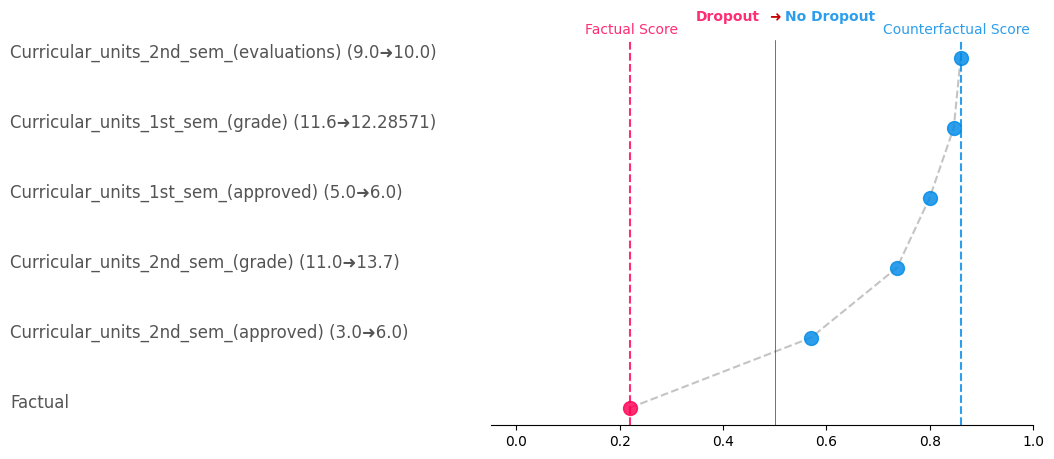

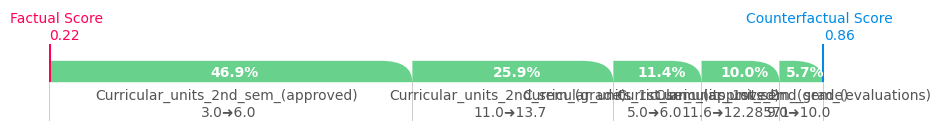

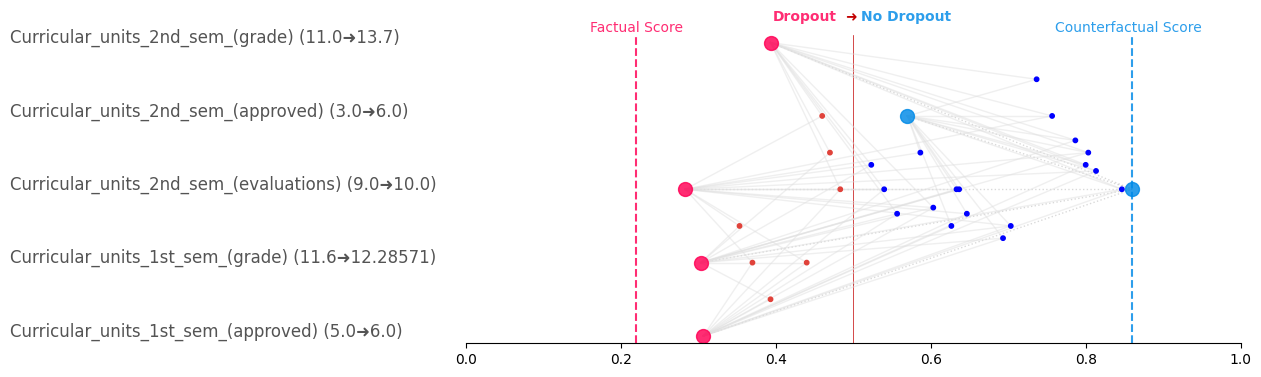

In [ ]:
out_exp[9].greedy()
out_exp[9].countershapley()
out_exp[9].constellation()

### Individual counterfactuals plot

In [369]:
# Same student used as the group counterfactual plot
counterfactual_plot_instance = exp.generate_counterfactuals(dict_clusters_students[0].iloc[[9]], total_CFs=1, desired_class=0, features_to_vary=features_to_vary)
counterfactual_plot_instance = counterfactual_plot_instance.cf_examples_list[0].final_cfs_df
counterfactual_plot_instance.drop(columns=["Target"], axis=1, inplace=True)

100%|██████████| 1/1 [00:00<00:00,  1.72it/s]


In [370]:
def model_pred(x):
    scores = exp.predict_fn(pd.concat([df_structure, pd.DataFrame(x, columns=feature_names)], ignore_index=True))
    return scores
    
feature_names = exp.data_interface.feature_names
df_structure = exp.data_interface.data_df[:0].loc[:, feature_names]
out_exp = []

out_exp.append(CreatePlot(
    factual=np.array(dict_clusters_students[0].iloc[9]),
    cf=np.array(counterfactual_plot_instance.squeeze()),
    model_pred=model_pred,
    feature_names=feature_names,
    class_names={0: 'No Dropout', 1: 'Dropout'}))

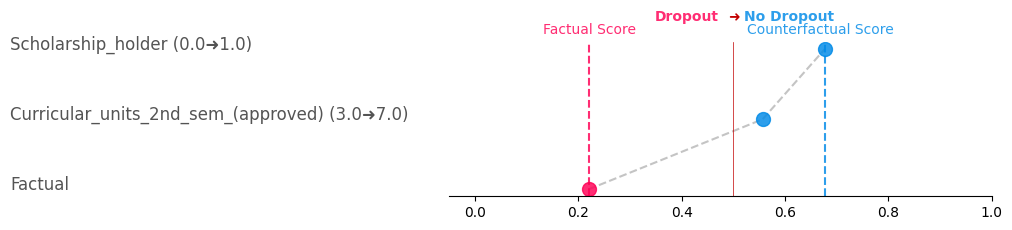

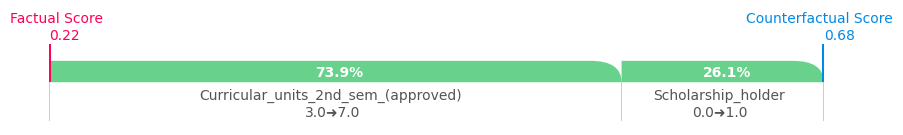

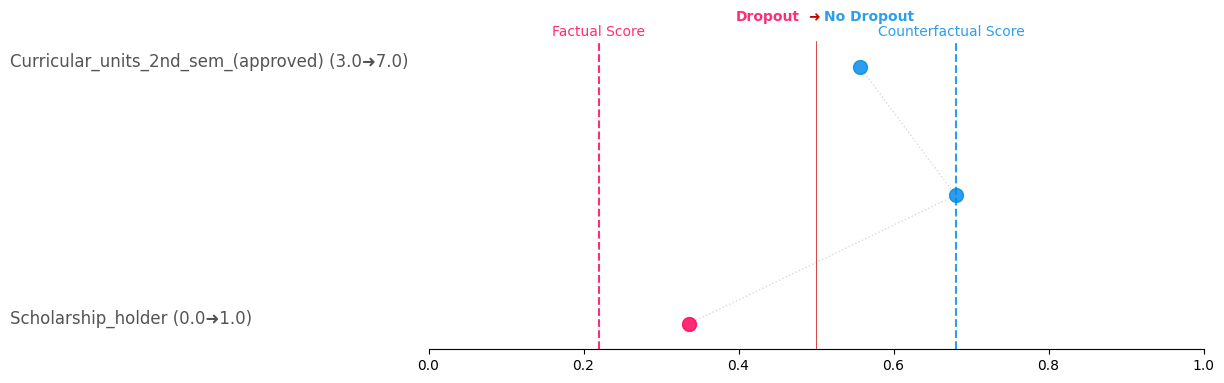

In [371]:
out_exp[0].greedy()
out_exp[0].countershapley()
out_exp[0].constellation()